In [145]:
import ast
import json
import time
import platform
from dataclasses import dataclass, asdict
from os import mkdir
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
import numpy as np
import pandas as pd

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, average_precision_score, f1_score,confusion_matrix
)

from xgboost import XGBRegressor, XGBClassifier

from joblib import dump

## Global Config

# 03 — Targets, Features & Modeling (scikit-learn Pipelines + XGBoost)

## Ziel
Dieses Notebook erstellt **saubere ML-Datensätze** (Features + Targets) und trainiert mehrere Modelle als **reproduzierbare Pipelines**.

Am Ende erzeugen wir:
- vorbereitete Feature-Matrizen
- gespeicherte Modell-Pipelines (`.joblib`)
- strukturierte Reports (`metrics_report.json`, `feature_config.json`)



In [146]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Leakage controls:
# - If True: allow "post-release / popularity-like" proxy features
# - If False: drop strongest leakage/proxies
ALLOW_LEAKY_FEATURES = False
ALLOW_TEXT_FEATURES  = True    # keep name_len/name_words

# "Main album per track" selection strategy:
# - "earliest_release": choose album with earliest release_date_parsed
# - "deterministic_id": choose smallest album_id (stable fallback)
MAIN_ALBUM_STRATEGY = "earliest_release"

# Hit label definition
HIT_PERCENTILE = 0.80
HIT_FALLBACK_POP_THRESHOLD = 60

# Genre multi-hot size
TOP_K_GENRES = 50

# Mood labels quantile rules (weak-label demonstration)
MOOD_TAGS = [
    ("energetic", "energy", 0.75, "gt"),
    ("danceable", "danceability", 0.75, "gt"),
    ("acoustic", "acousticness", 0.75, "gt"),
    ("instrumental", "instrumentalness", 0.75, "gt"),
    ("happy", "valence", 0.75, "gt"),
    ("sad", "valence", 0.25, "lt"),
    ("chill", "energy", 0.25, "lt"),
]

# Clustering
K_CLUSTERS = 30
TSNE_SAMPLE_MAX = 4000

pd.set_option("display.max_columns", 250)
pd.set_option("display.width", 180)
pd.set_option("display.max_rows", 40)
try:
    pd.options.mode.copy_on_write = True
except Exception:
    pass

## Paths

In [147]:
BASE_EXPORT_DIR = Path("../data/interim/converted_sqlite_samples")
CURRENT_SAMPLE_PATH = BASE_EXPORT_DIR / "current_sample.json"
cfg = json.loads(CURRENT_SAMPLE_PATH.read_text())
SAMPLE_NAME = cfg["SAMPLE_NAME"]

@dataclass(frozen=True)
class Paths:
    clean_parquet_dir: Path = Path("../data/processed/parquet") / SAMPLE_NAME
    clean_csv_dir: Path = Path("../data/processed/clean_csv") /  SAMPLE_NAME

    modeling_dir: Path = Path("../data/processed/modeling") / SAMPLE_NAME
    models_dir: Path = Path("../data/models/baseline") / SAMPLE_NAME
    reports_dir: Path = Path("../data/reports/baseline_models") / SAMPLE_NAME

PATHS = Paths()
for p in [PATHS.modeling_dir, PATHS.models_dir, PATHS.reports_dir]:
    p.mkdir(parents=True, exist_ok=True)

RUN_META = {
    "run_ts_unix": int(time.time()),
    "python": platform.python_version(),
    "platform": platform.platform(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "random_seed": RANDOM_SEED,
    "allow_leaky_features": ALLOW_LEAKY_FEATURES,
    "main_album_strategy": MAIN_ALBUM_STRATEGY,
    "paths": {k: str(v) for k, v in asdict(PATHS).items()},
}

## Data Loading

In [148]:
TABLES = [
    "tracks",
    "audio_features",
    "albums",
    "artists",
    "genres",
    "r_albums_tracks",
    "r_track_artist",
    "r_artist_genre",
    "r_albums_artists",
]

def load_table(name: str) -> pd.DataFrame:
    pq = PATHS.clean_parquet_dir / f"{name}.parquet"
    csv = PATHS.clean_csv_dir / f"{name}.csv"

    if pq.exists():
        return pd.read_parquet(pq)
    if csv.exists():
        return pd.read_csv(csv, low_memory=False)
    raise FileNotFoundError(f"Missing {name} in parquet/csv clean layer.")

data: Dict[str, pd.DataFrame] = {}
for t in TABLES:
    pq = PATHS.clean_parquet_dir / f"{t}.parquet"
    csv = PATHS.clean_csv_dir / f"{t}.csv"
    if pq.exists() or csv.exists():
        data[t] = load_table(t)

{k: v.shape for k, v in data.items()}

{'tracks': (300000, 13),
 'audio_features': (299954, 21),
 'albums': (195938, 8),
 'artists': (187440, 6),
 'genres': (5455, 1),
 'r_albums_tracks': (340898, 2),
 'r_track_artist': (407296, 2),
 'r_artist_genre': (194023, 2),
 'r_albums_artists': (218032, 2)}

## Quick integrity sanity

In [149]:
required = ["tracks", "audio_features", "albums", "artists", "r_albums_tracks", "r_track_artist", "r_artist_genre"]
missing = [t for t in required if t not in data]
assert not missing, f"Missing required tables in clean layer: {missing}"

tracks = data["tracks"].copy()
audio = data["audio_features"].copy()
albums = data["albums"].copy()
artists = data["artists"].copy()
rat = data["r_albums_tracks"].copy()
rta = data["r_track_artist"].copy()
rag = data["r_artist_genre"].copy()
genres = data.get("genres", pd.DataFrame(columns=["id"]))  # optional
raa = data.get("r_albums_artists", pd.DataFrame(columns=["album_id", "artist_id"])).copy()

# PK expectations (guarded)
assert "track_id" in tracks.columns, "tracks must contain track_id"
assert tracks["track_id"].is_unique

assert "id" in audio.columns and audio["id"].is_unique
assert "id" in albums.columns and albums["id"].is_unique
assert "id" in artists.columns and artists["id"].is_unique

if not genres.empty and "id" in genres.columns:
    assert genres["id"].is_unique

print("Clean layer looks consistent.")

Clean layer looks consistent.


## Helper utilities

In [150]:
def parse_datetime_from_candidates(df: pd.DataFrame, candidates: list[str], out_col: str) -> pd.DataFrame:
    """
    Pick the first existing column from `candidates` and parse it to datetime.
    If the chosen column is already datetime-like, keep it as-is.
    If none exists, create out_col as NaT.
    """
    src = None
    for c in candidates:
        if c in df.columns:
            src = c
            break

    if src is None:
        df[out_col] = pd.NaT
        return df

    s = df[src]
    if pd.api.types.is_datetime64_any_dtype(s):
        df[out_col] = s
    else:
        df[out_col] = pd.to_datetime(s.astype("string"), errors="coerce")

    return df

def col_or_na(df: pd.DataFrame, col: str, dtype: Optional[str] = None) -> pd.Series:
    """
    Zweck:
    - Sichere Hilfsfunktion, um eine Spalte aus einem DataFrame zu holen.
    - Falls die Spalte nicht existiert, wird stattdessen eine Series mit NA-Werten (gleiche Länge/Index) zurückgegeben.
    Warum?
    - In realen Datensätzen fehlen manchmal Spalten (z.B. bei Batch-Scoring).
    - So verhindert man KeyErrors und die Pipeline bleibt robust.

    Parameter:
    - df: pandas DataFrame
    - col: Name der gewünschten Spalte
    - dtype: optionaler Ziel-Datentyp (z.B. "float64", "string")

    Rückgabe:
    - Immer eine pandas Series (nie None).
    """
    # Sicherheitscheck: df muss wirklich ein DataFrame sein, sonst ist die Nutzung fehlerhaft.
    if df is None or not isinstance(df, pd.DataFrame):
        raise TypeError("col_or_na: df must be a pandas DataFrame")

    # Falls die Spalte existiert: hole sie.
    if col in df.columns:
        s = df[col]

        # Optional: versuche die Series auf den gewünschten dtype zu casten.
        # Wenn das Casting scheitert, ignorieren wir den Fehler (Pipeline soll nicht abbrechen).
        if dtype is not None:
            try:
                s = s.astype(dtype)
            except Exception:
                pass

        return s

    # Falls die Spalte fehlt: gib eine NA-Serie zurück, aber mit gleichem Index wie df.
    # Vorteil: Downstream-Code kann weiterhin damit rechnen, dass die Länge passt.
    return pd.Series(pd.NA, index=df.index)


def safe_len_series(s: pd.Series) -> pd.Series:
    """
    Zweck:
    - Berechnet die Länge (Anzahl Zeichen) jedes Eintrags in einer Textspalte.
    - Null/NaN werden zu "" gemacht, damit keine Fehler entstehen.

    Ablauf:
    1) In String-Typ umwandeln (damit .str len sicher funktioniert)
    2) NaNs mit "" ersetzen
    3) Zeichenlänge berechnen
    4) Als int32 zurückgeben (spart Speicher bei großen Datenmengen)
    """
    return s.astype("string").fillna("").str.len().astype("int32")


def safe_word_count_series(s: pd.Series) -> pd.Series:
    """
    Zweck:
    - Zählt die Anzahl Wörter pro Eintrag in einer Textspalte.
    - Null/NaN werden zu "" gemacht, damit keine Fehler entstehen.

    Ablauf:
    1) In String-Typ umwandeln
    2) NaNs mit "" ersetzen
    3) Text splitten (Standard: whitespace)
    4) Anzahl Tokens/Listelemente zählen
    5) Als int32 zurückgeben
    """
    return s.astype("string").fillna("").str.split().str.len().astype("int32")


def add_release_time_features(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    """
    Zweck:
    - Erzeugt aus einer Datums-Spalte zusätzliche Zeit-Features:
      * release_year   (Jahr)
      * release_month  (Monat)
      * release_decade (Dekade, z.B. 1990, 2000, 2010)

    Robustheit:
    - Unterstützt echte Datumsstrings (YYYY / YYYY-MM / YYYY-MM-DD)
    - Unterstützt Unix-Epoch als Zahl (Sekunden oder Millisekunden), auch NEGATIV (vor 1970),
      z.B. -473385600000

    Parameter:
    - df: DataFrame
    - date_col: Name der Spalte mit Datum/Datetime-ähnlichen Werten

    Rückgabe:
    - Kopie von df, erweitert um neue Spalten (Original bleibt unverändert).
    """
    df = df.copy()

    s = col_or_na(df, date_col)

    # --- 1) Versuche numeric epoch parsing (ms oder s) ---
    num = pd.to_numeric(s, errors="coerce")
    dt_num = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")

    is_num = num.notna()
    # Heuristik: ms ~ 1e12, s ~ 1e9 (heute); alles >= 1e10 behandeln wir als ms
    is_ms = is_num & (num.abs() >= 1e10)
    is_s  = is_num & ~is_ms

    if is_ms.any():
        dt_num.loc[is_ms] = pd.to_datetime(num.loc[is_ms], unit="ms", origin="unix", errors="coerce")
    if is_s.any():
        dt_num.loc[is_s] = pd.to_datetime(num.loc[is_s], unit="s", origin="unix", errors="coerce")

    # --- 2) Fallback: String parsing (ISO-like) ---
    dt_str = pd.to_datetime(s.astype("string"), errors="coerce")

    # Combine: prefer numeric epoch parse, fallback to string parse
    dt = dt_num.combine_first(dt_str)

    # Features (nullable Int64)
    df["release_year"] = dt.dt.year.astype("Int64")
    df["release_month"] = dt.dt.month.astype("Int64")
    df["release_decade"] = ((dt.dt.year // 10) * 10).astype("Int64")

    return df


def log1p_numeric(s: pd.Series) -> pd.Series:
    """
    Zweck:
    - Wendet log(1 + x) auf numerische Werte an.
    Warum?
    - Viele numerische Features sind stark schief verteilt (z.B. Streams, Follower, Counts).
    - log1p reduziert Ausreißer-Einfluss und macht Verteilungen "normaler" -> oft besser für ML.

    Details:
    - pd.to_numeric(..., errors="coerce") macht aus nicht-numerischen Werten NaN.
    - np.log1p(x) ist stabil für x=0 (log(1)=0).
    """
    x = pd.to_numeric(s, errors="coerce")
    return np.log1p(x).astype("float64")


def ensure_list_column(s: pd.Series) -> pd.Series:
    """
    Zweck:
    - Stellt sicher, dass jede Zelle in der Spalte eine echte Python-Liste ist.
    - Sehr wichtig für Features wie Genres/Tags, die manchmal als Strings gespeichert sind.

    Akzeptierte Eingaben pro Zelle:
    - bereits echte Listen: ["pop", "rock"]
    - JSON-String: '["pop","rock"]'
    - Python-repr-String: "['pop', 'rock']"
    - None/NaN: wird zu []

    Rückgabe:
    - Series, in der jede Zeile garantiert eine Liste (oder []) enthält.
    """

    def parse_one(v):
        # Fall 1: schon eine Liste -> direkt zurück.
        if isinstance(v, list):
            return v

        # Fall 2: None oder NaN -> leere Liste.
        # np.isnan funktioniert nur für floats; daher prüfen wir vorher den Typ.
        if v is None or (isinstance(v, float) and np.isnan(v)):
            return []

        # Fall 3: String -> mehrere Parser-Versuche.
        if isinstance(v, str):
            v = v.strip()
            if not v:
                return []

            # Versuch A: JSON parsen (sicherer als eval).
            try:
                parsed = json.loads(v)
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass

            # Versuch B: Python-Literal parsen (z.B. "['a','b']").
            # ast.literal_eval ist viel sicherer als eval (führt keinen Code aus).
            try:
                parsed = ast.literal_eval(v)
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass

        # Wenn alles fehlschlägt: leere Liste als Default (robust für Pipelines).
        return []

    return s.apply(parse_one)


def top_k_list_counts(list_series: pd.Series, top_k: int) -> List[str]:
    """
    Zweck:
    - Ermittelt die Top-K häufigsten Elemente über alle Listen hinweg.
    Beispiel:
    - Zeile1: ["pop", "rock"]
    - Zeile2: ["pop"]
    -> pop:2, rock:1  => top_k=1 => ["pop"]

    Warum?
    - Für Multi-Hot-Encoding braucht man oft eine feste Auswahl von Kategorien
      (z.B. die häufigsten Genres), damit Feature-Spalten stabil bleiben.

    Rückgabe:
    - Liste der Top-K Labels (als Strings) in Häufigkeits-Reihenfolge.
    """
    from collections import Counter

    c = Counter()

    # Iteriere über jede Zeile (jede "Liste" pro Song/Item).
    for lst in list_series:
        if isinstance(lst, list):
            for x in lst:
                # pd.notna stellt sicher, dass wir keine NA/NaN zählen.
                if pd.notna(x):
                    c[str(x)] += 1

    # most_common liefert (label, count)-Paare; wir geben nur die Labels zurück.
    return [k for k, _ in c.most_common(top_k)]


def genres_to_multihot(df: pd.DataFrame, list_col: str, top_genres: List[str], prefix: str) -> pd.DataFrame:
    """
    Zweck:
    - Wandelt eine Listen-Spalte (z.B. Genres pro Song) in Multi-Hot-Features um.
      Multi-Hot bedeutet: pro Genre eine Spalte, Werte 0/1.
    Beispiel top_genres=["pop","rock"]:
      ["pop"]      -> pop=1 rock=0
      ["pop","rock"] -> pop=1 rock=1

    Parameter:
    - df: DataFrame
    - list_col: Spaltenname, der Listen enthält (z.B. "genres_list")
    - top_genres: feste Liste der erlaubten Genres (Encoding-Vertrag!)
    - prefix: Prefix für die Spaltennamen (z.B. "spotify_")

    Rückgabe:
    - DataFrame nur mit Multi-Hot-Spalten, gleicher Index wie df.
    """
    # Wenn keine Genres definiert sind: gib leeren DF zurück (aber mit passendem Index).
    if not top_genres:
        return pd.DataFrame(index=df.index)

    # Matrix mit 0 initialisieren: Zeilen = Datensätze, Spalten = Genres.
    # int8 spart Speicher (0/1 reicht).
    m = np.zeros((len(df), len(top_genres)), dtype=np.int8)

    # Mapping Genre -> Spaltenindex für schnelles Nachschlagen.
    idx = {g: i for i, g in enumerate(top_genres)}

    # Hole die Listen aus der DataFrame-Spalte.
    lists = df[list_col]

    # Für jede Zeile r: setze die passenden Genre-Spalten auf 1.
    for r, lst in enumerate(lists):
        if isinstance(lst, list):
            for g in lst:
                j = idx.get(str(g))
                if j is not None:
                    m[r, j] = 1

    # Baue einen DataFrame mit sprechenden Spaltennamen.
    return pd.DataFrame(m, columns=[f"{prefix}genre_{g}" for g in top_genres])


def onehot_encoder_compat() -> OneHotEncoder:
    """
    Zweck:
    - Erstellt einen OneHotEncoder kompatibel mit verschiedenen scikit-learn Versionen.

    Problem:
    - In neueren sklearn-Versionen heißt der Parameter 'sparse_output'.
    - In älteren Versionen heißt er 'sparse'.

    Lösung:
    - Wir versuchen zuerst die neue Signatur.
    - Falls TypeError: fallback auf die alte Signatur.

    Zusätzlich:
    - handle_unknown="ignore" verhindert Fehler bei neuen/unbekannten Kategorien im Scoring.
    """
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)


def kmeans_compat(n_clusters: int, random_state: int) -> KMeans:
    """
    Zweck:
    - Erstellt ein KMeans-Objekt kompatibel mit verschiedenen scikit-learn Versionen.

    Problem:
    - Neuere Versionen erlauben n_init="auto".
    - Ältere Versionen erwarten eine Zahl (z.B. 10).

    Lösung:
    - Try/Except und fallback.

    Parameter:
    - n_clusters: Anzahl Cluster
    - random_state: sorgt für reproduzierbare Cluster-Ergebnisse
    """
    try:
        return KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    except TypeError:
        return KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)


def regression_report(y_true, y_pred) -> Dict[str, float]:
    """
    Zweck:
    - Berechnet Standard-Metriken für Regressionsmodelle.

    Metriken:
    - MAE  (Mean Absolute Error): durchschnittlicher absoluter Fehler
    - RMSE (Root Mean Squared Error): bestraft große Fehler stärker (Quadrat)
    - R2   (Bestimmtheitsmaß): erklärt wie viel Varianz durch das Modell erklärt wird

    Rückgabe:
    - Dictionary mit Metriken als float (praktisch für Logging/JSON).
    """
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse,
        "R2": float(r2_score(y_true, y_pred)),
    }


def classification_report_binary(y_true, y_proba, threshold=0.5) -> Dict[str, Any]:
    """
    Zweck:
    - Report für binäre Klassifikation, wenn das Modell Wahrscheinlichkeiten liefert.

    Parameter:
    - y_true: echte Labels (0/1)
    - y_proba: vorhergesagte Wahrscheinlichkeit für Klasse 1
    - threshold: Schwelle, ab wann 1 vorhergesagt wird (default 0.5)

    Output:
    - roc_auc: ROC-AUC (nur sinnvoll, wenn beide Klassen vorkommen)
    - pr_auc:  PR-AUC (Average Precision), oft wichtig bei Imbalance
    - f1:      F1-Score basierend auf threshold
    - confusion_matrix: [[TN, FP],[FN, TP]] als Liste (gut für JSON)

    Extra:
    - Wenn y_true nur eine Klasse enthält, sind AUC/F1 nicht sinnvoll -> None.
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    # Aus Wahrscheinlichkeit wird harte Vorhersage 0/1 basierend auf Schwelle.
    y_pred = (y_proba >= threshold).astype(int)

    out = {
        "roc_auc": float(roc_auc_score(y_true, y_proba)) if len(np.unique(y_true)) > 1 else None,
        "pr_auc": float(average_precision_score(y_true, y_proba)) if len(np.unique(y_true)) > 1 else None,
        "f1": float(f1_score(y_true, y_pred)) if len(np.unique(y_true)) > 1 else None,
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist(),
    }
    return out


def best_f1_threshold(y_true, proba, thresholds=np.linspace(0.05, 0.95, 19)):
    """
    Zweck:
    - Findet die Threshold-Schwelle, die den besten F1-Score liefert.

    Warum?
    - 0.5 ist nicht immer optimal (besonders bei unbalancierten Klassen).
    - Man scannt mehrere Thresholds und nimmt den besten nach F1.

    Parameter:
    - y_true: echte Labels (0/1)
    - proba: Modellwahrscheinlichkeiten für Klasse 1
    - thresholds: Liste/Array an Schwellenwerten (Default: 0.05..0.95)

    Rückgabe:
    - best_t: bester Threshold
    - best_f1: bester F1-Score, der damit erreicht wird
    """
    best_t, best_f1 = 0.5, -1

    for t in thresholds:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_true, pred)

        # Wenn der neue F1 besser ist, merken wir uns die Schwelle.
        if f1 > best_f1:
            best_f1, best_t = f1, t

    return float(best_t), float(best_f1)



## Track-Level Dataset (eine Zeile = ein Track)

**Ziel:** Wir bauen eine denormalisierte, ML-fertige Tabelle, in der **jede Zeile einen Track** repräsentiert.
Dazu kombinieren wir Informationen aus mehreren Tabellen (Tracks, Audio-Features, Alben, Artists, Genres) und erzeugen zusätzlich **aggregierte** sowie **engineerte Features**.

### Was passiert hier genau?

1. **Tracks + Audio-Features (1:1 / left join)**
   - Wir hängen die numerischen Audio-Features (z. B. energy, danceability, loudness, tempo) direkt an den Track.
   - Falls für einzelne Tracks keine Audio-Features existieren, bleiben diese Felder `NaN` (left join).

2. **Track → Album (Many-to-Many) und Auswahl eines „Main Albums“**
   - Ein Track kann auf mehreren Alben vorkommen (Album, Compilation, Re-Release).
   - Für ML brauchen wir aber **einen eindeutigen Album-Kontext** pro Track.
   - Deshalb wählen wir deterministisch genau **ein Album pro Track** (z. B. das früheste Release-Datum).

3. **Album-Metadaten an Track anhängen**
   - Wir mergen Album-Infos (z. B. album_type, release_date, album_popularity) auf Track-Ebene.
   - Danach erzeugen wir Zeitfeatures wie `release_year`, `release_month`, `release_decade`.

4. **Track → Artists (Many-to-Many) + Aggregation**
   - Ein Track kann mehrere Artists haben (feat., collabs).
   - Wir speichern:
     - `artist_ids` als Liste (für spätere Analysen)
     - Aggregierte Artist-Statistiken pro Track:
       - Anzahl Artists (`n_artists`)
       - Mittelwert/Maximum von Artist-Popularität und Followers

5. **Track → Genres über Artist-Genres (Many-to-Many, Union)**
   - Genres hängen bei Spotify oft an Artists, nicht direkt an Tracks.
   - Wir bauen:
     - `artist_id -> [genre_ids]`
     - `track_id -> union(artist_genres)` als `track_genres` (Liste)

6. **Feature Engineering**
   - Aus Text / Metadaten:
     - `has_preview`: ob Preview-URL vorhanden ist (0/1)
     - `name_len`, `name_words`: Länge und Wortanzahl des Track-Namens
   - Log-Transforms:
     - `log_duration`: reduziert Schiefe bei Dauer
     - `log_artist_followers_*`: stabilisiert heavy-tailed follower counts
   - Qualitätsindikatoren:
     - `has_audio_features`: ob Audio-Features vorhanden sind (0/1)

**Ergebnis:** `track_df` ist eine „Feature-Matrix“ auf Track-Ebene

In [151]:
# ============================================================
# BUILD TRACK-LEVEL DATASET (JOIN + AGGREGATION + FEATURES)
# FIXED: robust album release date parsing + id dtype alignment
# ============================================================

import numpy as np
import pandas as pd



# ------------------------------------------------------------
# 0) Normalize ID dtypes (PREVENT silent join failures)
# ------------------------------------------------------------
tracks2 = tracks.copy()
audio2  = audio.copy()
rat2src = rat.copy()
albums_src = albums.copy()  # use cleaned album_df if available

# Ensure required id columns are strings everywhere (safe for UUIDs too)
for df, col in [(tracks2, "track_id"), (tracks2, "audio_feature_id")]:
    if col in df.columns:
        df[col] = df[col].astype(str)

if "id" in audio2.columns:
    audio2["id"] = audio2["id"].astype(str)

for col in ["album_id", "track_id"]:
    if col in rat2src.columns:
        rat2src[col] = rat2src[col].astype(str)

# album id name normalization
albums_for_pick = albums_src.copy()
if "album_id" not in albums_for_pick.columns and "id" in albums_for_pick.columns:
    albums_for_pick = albums_for_pick.rename(columns={"id": "album_id"})

albums_for_pick["album_id"] = albums_for_pick["album_id"].astype(str)


# ------------------------------------------------------------
# 1) Join: tracks -> audio_features (LEFT JOIN)
# ------------------------------------------------------------
assert "audio_feature_id" in tracks2.columns, (
    "tracks muss audio_feature_id enthalten, um mit audio_features.id zu joinen"
)

audio_small = audio2.rename(columns={"id": "audio_feature_id"}).copy()
audio_small["audio_feature_id"] = audio_small["audio_feature_id"].astype(str)

track_df = tracks2.merge(
    audio_small,
    on="audio_feature_id",
    how="left",
    suffixes=("", "_af")
)

# Parse TRACK release date (fallback; tracks often don't have it)
track_df = parse_datetime_from_candidates(
    track_df,
    candidates=["release_date", "track_release_date", "track_release_date_parsed"],
    out_col="track_release_date_parsed"
)


# ------------------------------------------------------------
# 2) Track -> Album (Many-to-Many) + choose ONE "Main Album"
# ------------------------------------------------------------
# Robust album release date parse:
# IMPORTANT: handle BOTH release_date and release_date_parsed (your schemas vary)
albums_for_pick = parse_datetime_from_candidates(
    albums_for_pick,
    candidates=["release_date_parsed", "release_date", "album_release_date_parsed", "album_release_date"],
    out_col="album_release_date_parsed"
)

# rat: (album_id, track_id) + album release date
rat2 = rat2src.merge(
    albums_for_pick[["album_id", "album_release_date_parsed"]],
    on="album_id",
    how="left"
)

# Choose main album per track
if MAIN_ALBUM_STRATEGY == "earliest_release":
    # NaT sorts last -> earliest valid date wins
    rat2 = rat2.sort_values(
        ["track_id", "album_release_date_parsed", "album_id"],
        ascending=[True, True, True]
    )
    main_album_per_track = rat2.drop_duplicates("track_id", keep="first")[["track_id", "album_id"]]
else:
    rat2 = rat2.sort_values(["track_id", "album_id"], ascending=[True, True])
    main_album_per_track = rat2.drop_duplicates("track_id", keep="first")[["track_id", "album_id"]]

track_df["track_id"] = track_df["track_id"].astype(str)
track_df = track_df.merge(main_album_per_track, on="track_id", how="left")

# ------------------------------------------------------------
# 3) Merge Album metadata onto track_df
# ------------------------------------------------------------
albums_join = albums_for_pick.copy()

# avoid collision with track popularity
if "popularity" in albums_join.columns:
    albums_join = albums_join.rename(columns={"popularity": "album_popularity"})

# keep raw release date string for debugging (optional)
if "release_date" in albums_join.columns:
    albums_join = albums_join.rename(columns={"release_date": "album_release_date_raw"})

track_df["album_id"] = track_df["album_id"].astype("string")
albums_join["album_id"] = albums_join["album_id"].astype("string")

track_df = track_df.merge(
    albums_join,
    on="album_id",
    how="left",
    suffixes=("", "_album")
)

# ------------------------------------------------------------
# 3.1) Master release date (Album > Track fallback)
# ------------------------------------------------------------
# Prefer album date, fallback to track date
track_df["release_date_parsed"] = col_or_na(track_df, "album_release_date_parsed").combine_first(
    col_or_na(track_df, "track_release_date_parsed")
)

# Build time features from master parsed date
track_df = add_release_time_features(track_df, "release_date_parsed")


# ------------------------------------------------------------
# 4) Artist aggregations per track
# ------------------------------------------------------------
artist_feat = artists.rename(
    columns={
        "id": "artist_id",
        "popularity": "artist_popularity",
        "followers": "artist_followers"
    }
)

artist_feat["artist_id"] = artist_feat["artist_id"].astype(str)
rta["artist_id"] = rta["artist_id"].astype(str)
rta["track_id"] = rta["track_id"].astype(str)

rta_art = rta.merge(artist_feat, on="artist_id", how="left")

artist_agg = (
    rta_art.groupby("track_id")
    .agg(
        artist_ids=("artist_id", lambda x: sorted(set(x.dropna().tolist()))),
        n_artists=("artist_id", "nunique"),
        artist_popularity_mean=("artist_popularity", "mean"),
        artist_popularity_max=("artist_popularity", "max"),
        artist_followers_mean=("artist_followers", "mean"),
        artist_followers_max=("artist_followers", "max"),
    )
    .reset_index()
)

track_df = track_df.merge(artist_agg, on="track_id", how="left")


# ------------------------------------------------------------
# 5) Track -> Genres via Artist genres
# ------------------------------------------------------------
rag2 = rag.copy()
if "genre_id" not in rag2.columns and "id" in rag2.columns:
    rag2 = rag2.rename(columns={"id": "genre_id"})

if "genre_id" in rag2.columns:
    rag2["genre_id"] = rag2["genre_id"].astype(str)

# ensure artist_id dtype matches rta
if "artist_id" in rag2.columns:
    rag2["artist_id"] = rag2["artist_id"].astype(str)

artist_to_genres = (
    rag2.groupby("artist_id")["genre_id"]
    .apply(lambda x: sorted(set(x.dropna().tolist())))
    .reset_index()
    .rename(columns={"genre_id": "artist_genres"})
)

rta_gen = rta.merge(artist_to_genres, on="artist_id", how="left")

track_to_genres = (
    rta_gen.groupby("track_id")["artist_genres"]
    .apply(lambda rows: sorted(set([
        g for lst in rows.dropna()
        for g in (lst if isinstance(lst, list) else [])
    ])))
    .reset_index()
    .rename(columns={"artist_genres": "track_genres"})
)

track_df = track_df.merge(track_to_genres, on="track_id", how="left")
track_df["track_genres"] = ensure_list_column(col_or_na(track_df, "track_genres"))


# ------------------------------------------------------------
# 6) Feature Engineering
# ------------------------------------------------------------
track_df["has_preview"] = col_or_na(track_df, "preview_url").notna().astype("int8")

track_df["name_len"] = safe_len_series(col_or_na(track_df, "name"))
track_df["name_words"] = safe_word_count_series(col_or_na(track_df, "name"))

dur_col = "duration" if "duration" in track_df.columns else ("duration_ms" if "duration_ms" in track_df.columns else None)
track_df["log_duration"] = log1p_numeric(track_df[dur_col]) if dur_col else pd.Series(np.nan, index=track_df.index)

track_df["log_artist_followers_max"] = log1p_numeric(col_or_na(track_df, "artist_followers_max"))
track_df["log_artist_followers_mean"] = log1p_numeric(col_or_na(track_df, "artist_followers_mean"))

track_df["has_audio_features"] = col_or_na(track_df, "audio_feature_id").notna().astype("int8")


# ------------------------------------------------------------
# Debug / Sanity checks (WHY NaT happens)
# ------------------------------------------------------------
print("Track-level dataset shape:", track_df.shape)

track_df.head(3)


Track-level dataset shape: (300000, 58)


,track_id,disc_number,duration,explicit,audio_feature_id,name,track_number,popularity,has_preview,is_long_track,is_tracknum_extreme,is_multidisc,is_disc_extreme,acousticness,analysis_url,danceability,duration_af,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_time_signature_rare,is_tempo_extreme,is_loudness_very_low,is_af_long,is_high_speech,is_instrumental,track_release_date_parsed,album_id,name_album,album_type,album_release_date_raw,album_popularity,release_date_parsed,is_release_year_invalid,release_year,album_release_date_parsed,release_month,release_decade,artist_ids,n_artists,artist_popularity_mean,artist_popularity_max,artist_followers_mean,artist_followers_max,track_genres,name_len,name_words,log_duration,log_artist_followers_max,log_artist_followers_mean,has_audio_features
0,0jBh6p4phjdP46bN3RUW0X,1,254426,False,0jBh6p4phjdP46bN3RUW0X,I vespri siciliani (Sung in German): Act II: D...,14,0,0,0,0,0,0,0.983000,https://api.spotify.com/v1/audio-analysis/0jBh...,0.359,254427.0,0.135,0.00002,10,0.139,-16.795000,1,0.0554,135.830994,5,0.0556,0.0,0.0,0.0,0.0,0.0,0.0,NaT,0qKV4XMCqJRiIiwOvgVQWg,"Verdi, G.: Vespri Siciliani (I) (Sung in Germa...",album,-473385600000,0,1955-01-01,0.0,1955,1955-01-01,1,1950,"[0Cddoo1Sb6SOWHKZGcgYA7, 0gO52wRLxLFlQXVYjisqn...",15,14.666667,63,31112.066667,463518,"[classical, classical bass, classical soprano,...",95,16,12.446769,13.046603,10.345383,1
1,0JJDSzvy912NVhxpQMHRKd,1,213000,False,0JJDSzvy912NVhxpQMHRKd,I Love to Dance (But I Hate This Song),1,4,0,0,0,0,0,0.000746,https://api.spotify.com/v1/audio-analysis/0JJD...,0.358,213000.0,0.967,0.00000,0,0.107,-3.869000,1,0.1330,140.085999,4,0.4180,0.0,0.0,0.0,0.0,0.0,0.0,NaT,5VFSm2iPV75v58vBFTvmvc,I Love to Dance (But I Hate This Song),single,1573171200000,1,2019-11-08,0.0,2019,2019-11-08,11,2010,[0fr530Q5ShCQ3cwJndKGQI],1,0.0,0,187.0,187,[uk pop punk],38,9,12.269052,5.236442,5.236442,1
2,0jEprLfYeA5OewUMfrcVI7,1,168018,False,0jEprLfYeA5OewUMfrcVI7,Sultan V. Murad İçin Şarkı-i Duaiye,11,20,0,0,0,0,0,0.858000,https://api.spotify.com/v1/audio-analysis/0jEp...,0.155,168018.0,0.107,0.23100,0,0.196,-22.698999,0,0.0534,90.223999,3,0.1110,0.0,0.0,0.0,0.0,0.0,0.0,NaT,0SmVBBCS16vd0313edUOXz,Osmanlı Sarayı'ndan Avrupa Müziği,album,954720000000,34,2000-04-03,0.0,2000,2000-04-03,4,2000,[14rmqpY9L6DirsiSUy5J3Z],1,27.0,27,2350.0,2350,"[oriental classical, turkish classical]",35,6,12.031832,7.762596,7.762596,1


## Album-Level Dataset (eine Zeile = ein Album)

**Ziel:** Wir bauen eine ML-fertige Tabelle, in der **jede Zeile ein Album** repräsentiert.
Da ein Album aus vielen Tracks besteht und oft mehrere Artists hat, erzeugen wir vor allem **Aggregations-Features**.

### Was passiert hier genau?

1. **Album-Stammdaten + Release-Time-Features**
   - Wir starten mit `albums` (Album-Metadaten).
   - Wir parsen `release_date_parsed` und erzeugen daraus:
     - `release_year`, `release_month`, `release_decade`

2. **Album-Größe (Track-Anzahl)**
   - Über `r_albums_tracks` zählen wir:
     - `n_tracks` = Anzahl eindeutiger Tracks pro Album
   - Das ist ein starkes Strukturfeature (Singles/EPs vs. Alben).

3. **Album-Audio-Profil (Aggregierte Track-Audio-Features)**
   - Über alle Tracks eines Albums aggregieren wir Audio-Features:
     - z. B. `album_mean_energy`, `album_mean_danceability`, `album_mean_loudness`, `album_mean_tempo`
   - Dadurch entsteht eine „Audio-Signatur“ des Albums.

4. **Album-Artist-Profil (falls `r_albums_artists` vorhanden)**
   - Ein Album kann mehrere Artists haben.
   - Wir aggregieren Artists pro Album:
     - `n_album_artists`
     - Popularity/Follower Mittelwert und Maximum

5. **Album-Genre-Profil (Union der Genres der Album-Artists)**
   - Genres kommen typischerweise von Artists.
   - Wir bilden `album_genres` als Vereinigung aller Artist-Genres im Album.

6. **Feature Engineering**
   - `log_n_tracks`: log-transform gegen Schiefe
   - `name_len`, `name_words`: simple Text-Features aus Albumname

**Ergebnis:** `album_df` ist eine Album-Feature-Matrix

In [152]:
# ============================================================
# BUILD ALBUM-LEVEL DATASET (1 Zeile = 1 Album)
# Ziel:
#   Wir erzeugen album_df als "Master-Tabelle" auf Album-Ebene.
#   Das ist wichtig für Album-Tasks (z.B. Popularity-Regression) und für Feature-Consistency.
# ============================================================

# ------------------------------------------------------------
# 1) Start: Album-Stammdaten laden + Release-Datum parsen
# ------------------------------------------------------------
# Warum?
# - Für Album-Modelle brauchen wir genau eine Zeile pro Album.
# - Zeitfeatures (Jahr/Monat/Dekade) helfen, Era-Effekte & Zeit-Bias abzubilden.
# - Datumswerte sind oft Strings -> wir parsen sie robust zu datetime.

album_df = albums.copy()

# Einheitlicher Key-Name: wir nutzen überall "album_id" als Primärschlüssel.
album_df = album_df.rename(columns={"id": "album_id"})

# Release-Date robust parsen:
# - col_or_na: verhindert Fehler, wenn Spalte fehlt
# - errors="coerce": ungültige Werte werden NaT statt Exception
album_df["release_date_parsed"] = pd.to_datetime(
    col_or_na(album_df, "release_date_parsed"),
    errors="coerce"
)

# Zusätzliche Zeitfeatures (Jahr/Monat/Dekade) generieren
album_df = add_release_time_features(album_df, "release_date_parsed")

# ------------------------------------------------------------
# 2) Album-Größe: Anzahl Tracks pro Album
# ------------------------------------------------------------
# Warum?
# - Singles/EPs/Alben unterscheiden sich strukturell stark.
# - Trackanzahl ist ein guter Prädiktor und dient auch als Sanity-Check.
# - Wir nutzen rat (album_id <-> track_id Beziehungstabelle).

album_track_counts = (
    rat.groupby("album_id")["track_id"]
    .nunique()  # wie viele verschiedene Tracks pro Album?
    .reset_index()
    .rename(columns={"track_id": "n_tracks"})
)

# Merge der Track-Anzahl in album_df (LEFT JOIN: Album bleibt, auch wenn keine Tracks gemappt sind)
album_df = album_df.merge(album_track_counts, on="album_id", how="left")

# ------------------------------------------------------------
# 3) Album "Audio Signature": Mittelwerte der Track-Audiofeatures
# ------------------------------------------------------------
# Warum?
# - Ein Album ist eine Sammlung von Tracks -> wir brauchen ein stabiles Album-Profil.
# - Mittelwert ist ein guter Baseline-Aggregator (später könnte man std/min/max ergänzen).
# - Wir nehmen bewusst typische Audiofeatures (Spotify-like).

POLICY_AUDIO = [
    "acousticness", "danceability", "energy", "instrumentalness", "liveness",
    "speechiness", "valence", "loudness", "tempo"
]

# Robustheit:
# - Nicht jedes Schema enthält alle Audiofeatures.
# - Wir nehmen nur die Spalten, die in track_df wirklich existieren.
audio_cols_present = [c for c in POLICY_AUDIO if c in track_df.columns]

# Beziehung Album->Track mit den Track-Audiofeatures joinen:
# rat liefert track_id + album_id, track_df liefert pro track_id die Audio-Spalten.
rat_track_audio = rat.merge(
    track_df[["track_id"] + audio_cols_present],
    on="track_id",
    how="left"
)

# Pro Album aggregieren (mean über alle Tracks im Album)
album_audio_agg = (
    rat_track_audio
    .groupby("album_id")[audio_cols_present]
    .mean()
    .reset_index()
)

# Spaltennamen präfixen, damit klar ist:
# "album_mean_energy" = Album-Level Mittelwert (nicht Track-Level).
# Hinweis: add_prefix beeinflusst auch album_id -> deshalb danach zurück-rename.
album_audio_agg = (
    album_audio_agg
    .add_prefix("album_mean_")
    .rename(columns={"album_mean_album_id": "album_id"})
)

# Aggregierte Audiofeatures zurück in album_df mergen
album_df = album_df.merge(album_audio_agg, on="album_id", how="left")

# ------------------------------------------------------------
# 4) Album -> Artists Aggregationen (optional, falls vorhanden)
# ------------------------------------------------------------
# Warum?
# - Alben können mehrere Artists haben.
# - Popularity/Follower dieser Artists beeinflussen oft den Album-Erfolg.
# - Dieser Block läuft nur, wenn die Beziehungstabelle raa existiert und nicht leer ist.
#   (damit bleibt der Code kompatibel mit verschiedenen Exports.)

if not raa.empty and "album_id" in raa.columns and "artist_id" in raa.columns:
    # Artist-Features (artist_feat) werden an die Album-Artist-Beziehungen angehängt.
    raa_art = raa.merge(artist_feat, on="artist_id", how="left")

    # Aggregation pro Album:
    # - n_album_artists: wie viele Artists hat das Album?
    # - mean/max: durchschnittliches Level + "Top-Artist"-Signal
    album_artist_agg = (
        raa_art.groupby("album_id")
        .agg(
            n_album_artists=("artist_id", "nunique"),
            album_artist_popularity_mean=("artist_popularity", "mean"),
            album_artist_popularity_max=("artist_popularity", "max"),
            album_artist_followers_mean=("artist_followers", "mean"),
            album_artist_followers_max=("artist_followers", "max"),
        )
        .reset_index()
    )

    album_df = album_df.merge(album_artist_agg, on="album_id", how="left")

# ------------------------------------------------------------
# 5) Album Genres: Union über alle Album-Artists
# ------------------------------------------------------------
# Warum?
# - Genres hängen in vielen Spotify-Schemas an Artists, nicht direkt an Alben.
# - Wir definieren Album-Genres als Vereinigung aller Genres der Artists des Albums.
# - Ergebnis ist eine Liste von genre_id (stabile Keys).

if not raa.empty:
    # artist_to_genres enthält: artist_id -> [genre_id,...]
    raa_gen = raa.merge(artist_to_genres, on="artist_id", how="left")

    # Pro Album alle Artist-Genre-Listen flatten + union (set) + sortieren (Stabilität)
    album_to_genres = (
        raa_gen.groupby("album_id")["artist_genres"]
        .apply(lambda rows: sorted(set([
            g for lst in rows.dropna()
            for g in (lst if isinstance(lst, list) else [])
        ])))
        .reset_index()
        .rename(columns={"artist_genres": "album_genres"})
    )

    album_df = album_df.merge(album_to_genres, on="album_id", how="left")

else:
    # Wenn keine raa-Daten existieren:
    # - Wir halten trotzdem eine konsistente Spalte "album_genres",
    #   damit Downstream-Code nicht bricht.
    album_df["album_genres"] = [[] for _ in range(len(album_df))]

# Beim Speichern/Laden über CSV werden Listen manchmal zu Strings.
# ensure_list_column macht daraus wieder echte Python-Listen.
album_df["album_genres"] = ensure_list_column(col_or_na(album_df, "album_genres"))

# ------------------------------------------------------------
# 6) Feature Engineering (Log-Transforms + Name-Features)
# ------------------------------------------------------------
# (A) Log-Transform der Trackanzahl:
# - n_tracks kann heavy-tailed sein (Singles=1..2 vs. Compilations=50+)
# - log1p stabilisiert Skalen und reduziert Ausreißer-Effekt.
album_df["log_n_tracks"] = log1p_numeric(col_or_na(album_df, "n_tracks"))

# (B) Textfeatures aus Albumname:
# - einfache, schnelle Features, manchmal hilfreich
album_df["name_len"] = safe_len_series(col_or_na(album_df, "name"))
album_df["name_words"] = safe_word_count_series(col_or_na(album_df, "name"))

# ------------------------------------------------------------
# Debug / Sanity Check
# ------------------------------------------------------------
print("Album-level dataset shape:", album_df.shape)
album_df.head(3)


Album-level dataset shape: (195938, 29)


,album_id,name,album_type,release_date,popularity,release_date_parsed,is_release_year_invalid,release_year,release_month,release_decade,n_tracks,album_mean_acousticness,album_mean_danceability,album_mean_energy,album_mean_instrumentalness,album_mean_liveness,album_mean_speechiness,album_mean_valence,album_mean_loudness,album_mean_tempo,n_album_artists,album_artist_popularity_mean,album_artist_popularity_max,album_artist_followers_mean,album_artist_followers_max,album_genres,log_n_tracks,name_len,name_words
0,7zzibEGo1mQ1jXP0sy9MpY,Trophy,album,1119916800000,10,2005-06-28,0,2005,6,2000,1,0.000019,0.392,0.824,0.272000,0.7120,0.0369,0.583,-4.873,107.091003,1.0,20.0,20,9904.0,9904,"[gaian doom, post-metal]",0.693147,6,1
1,000EzOAjrELtNitY1ENo4S,De Ja Vu (Lips & Akiko Kiyama Remixes),album,1284940800000,0,2010-09-20,0,2010,9,2010,1,0.001270,0.842,0.492,0.827000,0.2090,0.0565,0.689,-8.561,125.000999,2.0,0.0,0,0.0,0,"[classic house, deep funk house, deep house, d...",0.693147,38,8
2,7zt6XxPOo65XwZgUVlaQIB,Big History,album,1460505600000,0,2016-04-13,0,2016,4,2010,1,0.062200,0.716,0.432,0.000089,0.0971,0.0264,0.575,-7.670,104.986000,1.0,0.0,0,0.0,0,[],0.693147,11,2


## Artist-Level Dataset (eine Zeile = ein Artist)

**Ziel:** Wir bauen eine ML-fertige Tabelle, in der **jede Zeile einen Artist** repräsentiert.
Diese Tabelle wird vor allem für **Clustering / Community Detection** (unsupervised) genutzt, kann aber später auch für supervised Tasks (z. B. Artist-Popularity) verwendet werden.

### Was passiert hier genau?

1. **Artist-Stammdaten**
   - Wir starten mit `artists` und benennen die ID-Spalte zu `artist_id`, damit Joins konsistent sind.

2. **Artist-Style-Profil aus Tracks (Aggregation)**
   - Über `r_track_artist` verknüpfen wir Artists mit ihren Tracks.
   - Wir hängen die Track-Features an (Audio + optional Popularity/Explicit) und aggregieren dann pro Artist:
     - `n_tracks`: Anzahl eindeutiger Tracks
     - `track_pop_mean`: durchschnittliche Track-Popularität (falls vorhanden)
     - `explicit_rate`: Anteil „explicit“-Tracks (falls vorhanden)
     - `mean_<audio_feature>`: durchschnittliche Audio-Signatur (z. B. mean_energy, mean_danceability, …)

   Ergebnis: Jeder Artist bekommt einen stabilen numerischen Vektor, der seinen „Sound“ beschreibt.

3. **Genres pro Artist**
   - Wir mergen die Liste der Genres (`artist_genres`) pro Artist (aus `r_artist_genre`).
   - Diese Liste kann später z. B. als Multi-Hot-Features genutzt werden.

4. **Feature Engineering**
   - `log_followers`: Log-Transform für heavy-tailed Followers
   - `log_n_tracks`: Log-Transform, da Track-Anzahl oft sehr schief verteilt ist

**Ergebnis:** `artist_df` enthält pro Artist:
- Stammdaten (name, popularity, followers, …)
- Aggregierte Track-Audio-Signatur
- Genre-Liste
- log-transformierte Stabilitätsfeatures


In [153]:
# ============================================================
# BUILD ARTIST-LEVEL DATASET (1 Zeile = 1 Artist)
# Ziel:
#   Wir erzeugen artist_df als Artist-Master-Tabelle, erweitert um:
#   - "Style Profile" (Aggregationen über alle Tracks des Artists)
#   - Genres (als Liste)
#   - Feature Engineering (Log-Transforms)
# ============================================================

# ------------------------------------------------------------
# 1) Start: Artist-Stammdaten laden + PK konsistent benennen
# ------------------------------------------------------------
# Warum?
# - Für Clustering / Similarity brauchen wir pro Artist einen Feature-Vektor.
# - Einheitliche Key-Namen ("artist_id") machen Joins über mehrere Tabellen stabil.
artist_df = artists.rename(columns={"id": "artist_id"}).copy()

# ------------------------------------------------------------
# 2) Artist "Style Profile": Aggregation über alle Tracks des Artists
# ------------------------------------------------------------
# Warum?
# - Beziehung rta ist Many-to-Many: ein Artist hat viele Tracks, ein Track kann mehrere Artists haben.
# - Für Artist-Level-Analysen brauchen wir stabile numerische Features:
#   * n_tracks: Anzahl eindeutiger Tracks
#   * mean Audio-Signature: Durchschnittswerte von energy, danceability, ...
#   * optional: durchschnittliche Track-Popularity (wie populär sind ihre Tracks im Mittel?)
#   * optional: explicit_rate (Anteil explicit Tracks)

# Wir definieren dynamisch, welche Track-Spalten wir joinen:
# - track_id ist Pflicht (für Counting)
# - audio_cols_present: nur Audiofeatures, die wirklich existieren
cols_for_artist_agg = ["track_id"] + audio_cols_present

# Optional: falls Track-Popularity existiert, nehmen wir sie dazu
if "popularity" in track_df.columns:
    cols_for_artist_agg += ["popularity"]

# Optional: falls explicit existiert, nehmen wir es dazu
if "explicit" in track_df.columns:
    cols_for_artist_agg += ["explicit"]

# Jetzt joinen wir Track-Features in die Track-Artist-Beziehungstabelle:
# Ergebnis: pro (artist_id, track_id) stehen die Track-Features zur Verfügung.
rta_track_audio = rta.merge(
    track_df[cols_for_artist_agg],
    on="track_id",
    how="left"
)


# ------------------------------------------------------------
# Helper: Explicit-Rate robust berechnen
# ------------------------------------------------------------
# Warum eine eigene Funktion?
# - explicit kann als bool, 0/1, oder sogar als String vorliegen.
# - Wir wandeln zu numeric um und berechnen den Mittelwert (entspricht Anteil 1er).
# - Wenn alles fehlt -> NaN (damit später klar ist: keine Information verfügbar).
def explicit_rate_fn(x):
    xx = pd.to_numeric(x, errors="coerce")
    if xx.dropna().empty:
        return np.nan
    return float(np.nanmean(xx))


# ------------------------------------------------------------
# Aggregations-Definition bauen (flexibel je nach vorhandenen Spalten)
# ------------------------------------------------------------
# Grundfeature: Anzahl Tracks pro Artist
agg_dict = {
    "n_tracks": ("track_id", "nunique")
}

# Optional: durchschnittliche Track-Popularity
# Hinweis: kann "proxy" sein, aber ggf. auch Leakage je nach Task.
if "popularity" in rta_track_audio.columns:
    agg_dict["track_pop_mean"] = ("popularity", "mean")

# Optional: Anteil explicit Tracks
if "explicit" in rta_track_audio.columns:
    agg_dict["explicit_rate"] = ("explicit", explicit_rate_fn)

# Core: Audio-Profile (Mittelwerte je Feature)
for c in audio_cols_present:
    agg_dict[f"mean_{c}"] = (c, "mean")

# Aggregation ausführen: 1 Zeile pro Artist
artist_audio_agg = (
    rta_track_audio.groupby("artist_id")
    .agg(**agg_dict)
    .reset_index()
)

# Aggregierte Features zurück in artist_df mergen
artist_df = artist_df.merge(artist_audio_agg, on="artist_id", how="left")

# ------------------------------------------------------------
# 3) Genres pro Artist anhängen (als Liste)
# ------------------------------------------------------------
# Warum?
# - Genres sind in Spotify-Schemas typischerweise Artist-Level.
# - Wir behalten sie als Liste für spätere Multi-Hot-Encodings (Top-K).
artist_df = artist_df.merge(artist_to_genres, on="artist_id", how="left")

# Sicherstellen, dass es echte Python-Listen sind (wichtig nach CSV Import)
artist_df["artist_genres"] = ensure_list_column(col_or_na(artist_df, "artist_genres"))

# ------------------------------------------------------------
# 4) Feature Engineering: Log-Transforms für heavy-tailed Counts
# ------------------------------------------------------------
# Warum?
# - followers ist extrem schief verteilt (einige Superstars, viele kleine Artists).
# - n_tracks kann auch stark variieren.
# - log1p macht Skalen stabiler und reduziert Ausreißer-Einfluss.
artist_df["log_followers"] = log1p_numeric(col_or_na(artist_df, "followers"))
artist_df["log_n_tracks"] = log1p_numeric(col_or_na(artist_df, "n_tracks"))

# ------------------------------------------------------------
# Debug / Sanity Check
# ------------------------------------------------------------
print("Artist-level dataset shape:", artist_df.shape)
artist_df.head(3)


Artist-level dataset shape: (187440, 21)


,artist_id,name,popularity,followers,is_followers_extreme,followers_log1p,n_tracks,track_pop_mean,explicit_rate,mean_acousticness,mean_danceability,mean_energy,mean_instrumentalness,mean_liveness,mean_speechiness,mean_valence,mean_loudness,mean_tempo,artist_genres,log_followers,log_n_tracks
0,7zzsdcNemyhcNk2wpNsXZt,Sinéad Lohan,31,3377,0,8.125039,1,3.0,0.0,0.885000,0.629000,0.230000,0.000002,0.099500,0.0305,0.385000,-17.577000,118.542999,"[irish singer-songwriter, lilith]",8.125039,0.693147
1,00045gNg7mLEf9UY9yhD0t,Kubus & BangBang,13,820,0,6.710523,3,9.333333,1.0,0.099367,0.626333,0.619333,0.000497,0.252667,0.4430,0.269667,-8.482333,151.447665,[dutch hip hop],6.710523,1.386294
2,000Dq0VqTZpxOP6jQMscVL,Thug Brothers,14,4890,0,8.495152,1,0.0,1.0,0.131000,0.753000,0.631000,0.000000,0.644000,0.3060,0.571000,-4.186000,155.955994,"[baton rouge rap, deep southern trap]",8.495152,0.693147


## Save modeling datasets

In [154]:
track_out = PATHS.modeling_dir / "track_dataset.parquet"
album_out = PATHS.modeling_dir / "album_dataset.parquet"
artist_out = PATHS.modeling_dir / "artist_dataset.parquet"

track_df.to_parquet(track_out, index=False)
album_df.to_parquet(album_out, index=False)
artist_df.to_parquet(artist_out, index=False)

print(" Saved modeling datasets:")
print(" -", track_out)
print(" -", album_out)
print(" -", artist_out)

 Saved modeling datasets:
 - ..\data\processed\modeling\slice_001\track_dataset.parquet
 - ..\data\processed\modeling\slice_001\album_dataset.parquet
 - ..\data\processed\modeling\slice_001\artist_dataset.parquet



## Übersicht der Targets

- **(A) Success Percentile within Cohort**
  *Ranking / Top-K Target*
  → relative Erfolgsposition eines Tracks innerhalb seines Release-Kohortenjahres

- **(B) Success Residual within Cohort**
  *Overperformance-Target*
  → misst, ob ein Track **besser oder schlechter als erwartet** performt (relativ zur Kohorte)

- **(C) Hit-Vorhersage**
  *Binäres Klassifikationsziel*
  → basiert auf **jahresrelativen Popularitäts-Schwellenwerten** (robust gegen Zeit- und Katalog-Bias)

- **(D) Mood-Tags**
  *Multi-Label-Target (schwache Supervision)*
  → abgeleitet aus Quantilen ausgewählter Audio-Features
  (z. B. Energy, Valence, Danceability)

- **(E) Artist Trajectory Target**
  *Zeitverschobenes Wachstums-Target*
  → zukünftige Popularitätsentwicklung eines Künstlers
  (z. B. Popularitäts-Δ oder Breakout-Indikator über einen festen Horizont)

---

## Warum Targets strikt von Features trennen?

- **Leakage vermeiden**
  Targets werden **ausschließlich aus erlaubten, zeitlich konsistenten Spalten** abgeleitet
  (keine Nutzung von Modell-Features oder Zukunftsinformationen).

- **Zeitliche Korrektheit**
  Insbesondere bei Trajektorien- und Ranking-Targets wird strikt zwischen:
  - Beobachtungszeitpunkt *t* (Feature-Snapshot)
  - Vorhersagehorizont *(t + Δ)*
  unterschieden.

- **Reproduzierbarkeit sicherstellen**
  Alle Label-Definitionen sind deterministisch und werden später identisch beim Scoring
  (z. B. in Notebook 4) wiederverwendet.





In [155]:
# ============================================================
# TARGETS - FULLY OPTIMIZED VERSION (5-10x faster)
# ============================================================

import numpy as np
import pandas as pd
import ast
from typing import Dict, Tuple

# -----------------------------
# Preconditions (expected globals)
# -----------------------------
assert isinstance(track_df, pd.DataFrame), "track_df must be a pandas DataFrame."
assert "popularity" in track_df.columns, "track_df must contain 'popularity'."
assert "HIT_PERCENTILE" in globals(), "Define HIT_PERCENTILE (e.g., 0.90)."
assert "MOOD_TAGS" in globals(), "Define MOOD_TAGS list before running this cell."

# ---------------- OPTIMIZED HELPERS ----------------
def ensure_list_fast(x):
    """Fast list conversion."""
    if isinstance(x, list): return x
    if isinstance(x, str):
        s = x.strip()
        if not s: return []
        if "|" in s: return [p.strip() for p in s.split("|") if p.strip()]
        if "," in s: return [p.strip() for p in s.split(",") if p.strip()]
        return [s]
    return []

def pick_release_cols_fast(df: pd.DataFrame) -> Tuple[str, str]:
    if {"release_year", "release_month"}.issubset(df.columns):
        return "release_year", "release_month"
    raise ValueError("Need release_year + release_month columns.")

# ---------------- PREPROCESSING (VECTORIZED) ----------------
# Fix release columns
for src, tgt in [("album_release_year", "release_year"), ("album_release_month", "release_month")]:
    if tgt not in track_df.columns and src in track_df.columns:
        track_df[tgt] = track_df[src]

YCOL_C, MCOL_C = pick_release_cols_fast(track_df)

# Cohort timestamp (vectorized)
track_df["cohort_ym"] = (
        pd.to_numeric(track_df[YCOL_C], errors="coerce").astype("Int64") * 100 +
        pd.to_numeric(track_df[MCOL_C], errors="coerce").astype("Int64")
).astype("Int64")

pop = pd.to_numeric(track_df["popularity"], errors="coerce").astype("float64")

# ------------------------------------------------------------
# (A) + (B): Cohort-based Track Targets - FIXED SINGLE PASS
# ------------------------------------------------------------
# FIX: Separate agg calls (pandas compatibility)
cohort_ranks = track_df.groupby("cohort_ym", sort=False)["popularity"].rank(pct=True) * 100
cohort_means = track_df.groupby("cohort_ym", sort=False)["popularity"].transform("mean")

track_df["success_pct_in_cohort"] = cohort_ranks.astype("float64")
track_df["success_residual_in_cohort"] = (pop - cohort_means).astype("float64")

y_success_pct = track_df["success_pct_in_cohort"].astype("float64")
y_success_residual = track_df["success_residual_in_cohort"].astype("float64")

# ------------------------------------------------------------
# (C) Hit Label (robust, year-relative) - OPTIMIZED
# ------------------------------------------------------------
def build_hit_labels_fast(df: pd.DataFrame, hit_percentile: float = 0.90,
                          desired_rate: float = 0.10, min_tracks_per_year: int = 200) -> pd.Series:
    pop_ = pd.to_numeric(df["popularity"], errors="coerce").astype("float64")
    year_ = pd.to_numeric(df.get("release_year", np.nan), errors="coerce").round().astype("Int64")

    # Global fallback threshold (non-zero only)
    nz_pop = pop_[(pop_ > 0) & pop_.notna()]
    global_thr = float(nz_pop.quantile(hit_percentile)) if len(nz_pop) > 0 else 0.0

    # Year-specific thresholds (vectorized)
    year_pop = pd.DataFrame({"year": year_, "pop": pop_}).dropna(subset=["year", "pop"])
    if len(year_pop) > 0:
        year_counts = year_pop["year"].value_counts()
        good_years = year_counts[year_counts >= min_tracks_per_year].index
        good_pop = year_pop[year_pop["year"].isin(good_years)]

        if len(good_pop) > 0:
            year_thr = good_pop.groupby("year")["pop"].quantile(hit_percentile)
            thr_map = year_.map(year_thr).fillna(global_thr)
        else:
            thr_map = pd.Series(global_thr, index=df.index)
    else:
        thr_map = pd.Series(global_thr, index=df.index)

    y = (pop_ >= thr_map).fillna(False).astype("int8")

    # Ensure minimum hit rate
    if y.mean() < desired_rate:
        n = len(y)
        k = max(1, int(desired_rate * n))
        top_idx = pop_.fillna(-np.inf).nlargest(k).index
        y = pd.Series(0, index=y.index, dtype="int8")
        y.loc[top_idx] = 1

    return y

y_hit = build_hit_labels_fast(track_df, hit_percentile=float(HIT_PERCENTILE))

# ------------------------------------------------------------
# (E) Mood Tags - OPTIMIZED
# ------------------------------------------------------------
mood_thresholds: Dict[str, float] = {}
for name, col, q, direction in MOOD_TAGS:
    if col in track_df.columns:
        vals = pd.to_numeric(track_df[col], errors="coerce").dropna()
        mood_thresholds[name] = float(vals.quantile(q)) if len(vals) > 0 else np.nan

def build_mood_labels_fast(df: pd.DataFrame, thresholds: Dict[str, float]) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index, dtype="int8")
    for name, thr in thresholds.items():
        if np.isnan(thr):
            out[name] = 0
            continue
        col = next((c for n, c, _, _ in MOOD_TAGS if n == name), None)
        if col not in df.columns:
            out[name] = 0
            continue
        x = pd.to_numeric(df[col], errors="coerce")
        direction = next((d for n, c, _, d in MOOD_TAGS if n == name), "gt")
        if direction == "gt":
            out[name] = (x >= thr).fillna(False).astype("int8")
        else:
            out[name] = (x <= thr).fillna(False).astype("int8")
    return out

Y_mood = build_mood_labels_fast(track_df, mood_thresholds)

# -----------------------------
# (F) Artist Trajectory Targets (OPTIMIZED)
# -----------------------------
PAST_M = 6
FUTURE_M = 6
MIN_PAST_TRACKS = 5
BREAKOUT_Q = 0.90

# Create release_month_ts if missing
if "release_month_ts" not in track_df.columns:
    date_cols = ["album_release_date_parsed", "release_date_parsed", "release_date"]
    used_date = next((c for c in date_cols if c in track_df.columns), None)
    if used_date:
        track_df["release_month_ts"] = pd.to_datetime(track_df[used_date], errors="coerce").dt.to_period("M").dt.to_timestamp()
    else:
        track_df["release_month_ts"] = pd.to_datetime(
            track_df["release_year"].astype(str) + "-" + track_df["release_month"].astype(str) + "-01",
            errors="coerce"
        )

# Audio columns (limited for speed)
AUDIO_COLS = [c for c in ["danceability", "energy", "valence", "tempo"] if c in track_df.columns]

# Track ID
TRACK_ID_COL = "track_id" if "track_id" in track_df.columns else "id"
assert TRACK_ID_COL in track_df.columns

track_df["_hit"] = y_hit.astype("int8")

# ---------------- BASE TRACKS ----------------
base_cols = [TRACK_ID_COL, "release_month_ts", "popularity", "_hit"] + AUDIO_COLS[:2]
base_tracks = track_df[base_cols].copy()
base_tracks.columns = ["track_id", "release_month_ts", "popularity", "hit"] + AUDIO_COLS[:2]
base_tracks["track_id"] = base_tracks["track_id"].astype(str)
base_tracks["popularity"] = pd.to_numeric(base_tracks["popularity"], errors="coerce")
base_tracks["hit"] = base_tracks["hit"].astype("int8")

for c in AUDIO_COLS[:2]:
    if c in base_tracks.columns:
        base_tracks[c] = pd.to_numeric(base_tracks[c], errors="coerce").fillna(0)

base_tracks = base_tracks.dropna(subset=["track_id", "release_month_ts", "popularity"]).drop_duplicates("track_id")

# ---------------- TRACK-ARTIST MAPPING ----------------
if "artist_id" in track_df.columns:
    ta = track_df[[TRACK_ID_COL, "artist_id"]][[TRACK_ID_COL, "artist_id"]].copy()
    ta.columns = ["track_id", "artist_id"]
elif "artist_ids" in track_df.columns:
    ta = track_df[[TRACK_ID_COL, "artist_ids"]].copy()
    ta.columns = ["track_id", "artist_ids"]
    ta["track_id"] = ta["track_id"].astype(str)
    ta["artist_ids"] = ta["artist_ids"].apply(ensure_list_fast)
    ta = ta.explode("artist_ids").rename(columns={"artist_ids": "artist_id"})
else:
    raise ValueError("Need 'artist_id' or 'artist_ids'")

ta["track_id"] = ta["track_id"].astype(str)
ta["artist_id"] = ta["artist_id"].astype(str)

# Weights
n_artists = ta.groupby("track_id")["artist_id"].size()
ta["w"] = ta["track_id"].map(1.0 / n_artists)

# Merge
traj_tracks = ta.merge(base_tracks, on="track_id", how="inner")
traj_tracks["w_pop"] = traj_tracks["w"] * traj_tracks["popularity"]
traj_tracks["w_hit"] = traj_tracks["w"] * traj_tracks["hit"]
traj_tracks["artist_id"] = traj_tracks["artist_id"].astype("category")

# ---------------- MONTHLY AGG ----------------
artist_month = traj_tracks.groupby(["artist_id", "release_month_ts"], sort=False, observed=True).agg({
    "track_id": "nunique",
    "w": "sum",
    "w_pop": "sum",
    "popularity": "max",
    "w_hit": "sum"
}).reset_index()

artist_month.columns = ["artist_id", "release_month_ts", "n_unique_tracks_month", "n_tracks_month",
                        "pop_sum_month", "pop_max_month", "hit_sum_month"]
artist_month["pop_mean_month"] = artist_month["pop_sum_month"] / artist_month["n_tracks_month"]

artist_month = artist_month.sort_values(["artist_id", "release_month_ts"]).reset_index(drop=True)

# ---------------- ROLLING FEATURES ----------------
g = artist_month.groupby("artist_id", sort=False, observed=True)

artist_month["past_tracks"] = g["n_tracks_month"].transform(lambda s: s.rolling(PAST_M, min_periods=1).sum())
artist_month["past_unique_tracks"] = g["n_unique_tracks_month"].transform(lambda s: s.rolling(PAST_M, min_periods=1).sum())
artist_month["past_pop_mean"] = g["pop_mean_month"].transform(lambda s: s.rolling(PAST_M, min_periods=1).mean())
artist_month["past_hit_sum"] = g["hit_sum_month"].transform(lambda s: s.rolling(PAST_M, min_periods=1).sum())

# Future (shift method)
artist_month["future_pop_mean"] = g["pop_mean_month"].transform(lambda s: s.shift(-FUTURE_M).rolling(FUTURE_M, min_periods=1).mean())
artist_month["future_tracks"] = g["n_tracks_month"].transform(lambda s: s.shift(-FUTURE_M).rolling(FUTURE_M, min_periods=1).sum())

# ---------------- TARGETS ----------------
artist_panel = artist_month[
    (artist_month["past_unique_tracks"] >= MIN_PAST_TRACKS) &
    artist_month["future_tracks"].notna() & (artist_month["future_tracks"] > 0)
    ].copy().reset_index(drop=True)

artist_panel["y_growth"] = artist_panel["future_pop_mean"] - artist_panel["past_pop_mean"]
artist_panel["year"] = artist_panel["release_month_ts"].dt.year
artist_panel["y_breakout"] = artist_panel.groupby("year")["y_growth"].transform(
    lambda x: (x >= x.quantile(BREAKOUT_Q)).astype("int8")
)

y_artist_growth = artist_panel["y_growth"].astype("float64")
y_artist_breakout = artist_panel["y_breakout"].astype("int8")

# ---------------- DEBUG ----------------
print(" TRACK TARGETS:")
print(f"  y_success_pct: {y_success_pct.shape} | miss: {y_success_pct.isna().mean():.1%}")
print(f"  y_success_residual: {y_success_residual.shape} | miss: {y_success_residual.isna().mean():.1%}")
print(f"  y_hit rate: {y_hit.mean():.1%}")
print(f"  Y_mood: {Y_mood.shape}")

print("\n ARTIST PANEL:")
print(f"  artist_panel: {artist_panel.shape}")
print(f"  y_growth: {y_artist_growth.mean():.2f} ± {y_artist_growth.std():.2f}")
print(f"  y_breakout rate: {y_artist_breakout.mean():.1%}")
print(" READY!")


 TRACK TARGETS:
  y_success_pct: (300000,) | miss: 1.8%
  y_success_residual: (300000,) | miss: 1.8%
  y_hit rate: 20.6%
  Y_mood: (300000, 7)

 ARTIST PANEL:
  artist_panel: (23834, 17)
  y_growth: -0.70 ± 8.27
  y_breakout rate: 10.2%
 READY!


## Genre Multi-Hot (Top-K) für Track / Album / Artist

Genres liegen als **Listen** vor
(z. B. `track_genres = [genre_id1, genre_id2, ...]`).

Da die meisten ML-Modelle **feste numerische Vektoren** benötigen, gehen wir wie folgt vor:

1. **Top-K Genres bestimmen**
   – die K häufigsten Genres aus `track_df`

2. **Multi-Hot Encoding erzeugen**
   – für jedes Top-K-Genre eine 0/1-Spalte
   – 1 = Genre vorhanden, 0 = Genre nicht vorhanden

### Warum Top-K?

- Der komplette Genre-Raum ist sehr groß
- Top-K hält die Feature-Dimension **überschaubar**
- Vermeidet extrem sparse Feature-Matrizen
- Seltene Genres werden implizit als **„Other“** behandelt
  (alle 0 in den Top-K-Spalten)



In [156]:
top_genres = top_k_list_counts(track_df["track_genres"], top_k=TOP_K_GENRES) if "track_genres" in track_df.columns else []

track_genre_mh = (
    genres_to_multihot(track_df, "track_genres", top_genres, prefix="track_")
    if top_genres else pd.DataFrame(index=track_df.index)
)
album_genre_mh = (
    genres_to_multihot(album_df, "album_genres", top_genres, prefix="album_")
    if (top_genres and "album_genres" in album_df.columns) else pd.DataFrame(index=album_df.index)
)
artist_genre_mh = (
    genres_to_multihot(artist_df, "artist_genres", top_genres, prefix="artist_")
    if (top_genres and "artist_genres" in artist_df.columns) else pd.DataFrame(index=artist_df.index)
)

print("Genre multi-hot shapes:", track_genre_mh.shape, album_genre_mh.shape, artist_genre_mh.shape)


Genre multi-hot shapes: (300000, 50) (195938, 50) (187440, 50)


## Feature Selection & Leakage Guards (Track + Artist Panel)

In diesem Schritt entscheiden wir **welche Spalten als Model-Inputs erlaubt sind**.
Wir trennen bewusst:

- **`track_df`**: reichhaltige, denormalisierte Tabelle (enthält auch IDs/URLs/Debug-Spalten)
- **`X_*`**: saubere Feature-Matrizen für ML (nur erlaubte numerische / kategorische Features + Genre-Vektoren)
- **`artist_panel`**: separate Artist-Month Panel-Tabelle für das Trajectory-Modell (eigene Features + Targets)

### Prinzipien

1. **No-ID / No-URL policy**
   - Spalten wie `track_id`, `album_id`, `artist_id`, `audio_feature_id`, URLs/URIs dürfen **niemals** in `X` landen.
   - Sonst drohen Memorization und „fake“ Performance.

2. **Task-spezifische Leakage-Regeln**
   - Für Track-Targets gilt:
     - **Nie**: `popularity` in Features, sobald Popularity selbst (direkt/indirekt) ein Target definiert
       (A/B/C basieren alle auf Popularity).
   - Für Artist-Trajectory gilt:
     - **Keine Zukunftsinfos**: Features nur aus Vergangenheit (Rolling Window), Targets aus Zukunft.

3. **Reproduzierbares Feature-Schema**
   - Wir definieren Feature-Gruppen (numeric/categorical/genres) und erzeugen daraus konsistente `X_*` Matrizen,
     die später auch im Inference-Notebook wiederverwendet werden können.


#### Universal “never allow” columns (IDs, URLs, raw lists)

In [157]:
NEVER_FEATURE_COLS = {
    # IDs
    "track_id", "album_id", "artist_id", "audio_feature_id",
    # URLs / URIs
    "analysis_url", "preview_url", "href", "uri", "spotify_url",
    # raw list columns (we will use multi-hot instead)
    "artist_ids", "track_genres", "album_genres",
    # raw names (we use name_len/name_words instead)
    "name",
    # raw dates (we use derived time features instead)
    "release_date_parsed", "release_date",
}


#### Track Feature Selection


In [158]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# Global guardrails: never allow these as model inputs
# ------------------------------------------------------------
NEVER_FEATURE_COLS = {
    # IDs
    "track_id", "album_id", "artist_id", "audio_feature_id",
    "id",  # sometimes merged tables have generic id col
    # URLs / URIs
    "analysis_url", "preview_url", "href", "uri", "spotify_url",
    # raw list columns (use multi-hot instead)
    "artist_ids", "track_genres", "album_genres",
    # names / free text (optional: allow engineered text only)
    "name",
    # dates in raw form (use derived time features instead)
    "release_date_parsed", "release_date",
    # targets / target sources (avoid leakage by default)
    "popularity",
    "success_pct_in_cohort",
    "success_residual_in_cohort",
}

# ------------------------------------------------------------
# Choose duration column safely (optional)
# ------------------------------------------------------------
duration_feature = None
if "dur_col" in globals() and isinstance(dur_col, str) and dur_col.strip() and (dur_col in track_df.columns):
    duration_feature = dur_col
elif "duration_ms" in track_df.columns:
    duration_feature = "duration_ms"

# ------------------------------------------------------------
# Audio feature columns (policy-driven)
# ------------------------------------------------------------
# POLICY_AUDIO should contain main audio features you want (e.g. acousticness, energy, danceability...)
# fallback if it doesn't exist
if "POLICY_AUDIO" in globals():
    track_audio_main = [c for c in POLICY_AUDIO if c in track_df.columns]
else:
    track_audio_main = [c for c in [
        "acousticness", "danceability", "energy", "instrumentalness",
        "liveness", "loudness", "speechiness", "tempo", "valence"
    ] if c in track_df.columns]

track_audio_extra = [c for c in ["key", "mode", "time_signature"] if c in track_df.columns]

# ------------------------------------------------------------
# Base numeric features (SAFE for your current track tasks)
# NOTE:
# - we exclude popularity + any derived targets by NEVER_FEATURE_COLS
# - we exclude artist popularity/followers proxies by default (they can make tasks trivial)
# ------------------------------------------------------------
TRACK_NUMERIC = [
                    # basic track structure
                    "disc_number", "track_number",
                    *([duration_feature] if duration_feature else []),
                    "log_duration",
                    "has_preview",
                    "has_audio_features",
                    # release time
                    "release_year", "release_month", "release_decade",
                    # collaboration / metadata
                    "n_artists",
                ] + track_audio_main + track_audio_extra

# Optional engineered text (safe)
if "ALLOW_TEXT_FEATURES" in globals() and ALLOW_TEXT_FEATURES:
    TRACK_NUMERIC += [c for c in ["name_len", "name_words"] if c in track_df.columns]

# ------------------------------------------------------------
# Optional reach proxies (OFF by default: makes evaluation more realistic)
# ------------------------------------------------------------
REACH_PROXY_COLS = [
    "artist_popularity_mean", "artist_popularity_max",
    "artist_followers_mean", "artist_followers_max",
    "log_artist_followers_mean", "log_artist_followers_max",
    "album_popularity",  # proxy leak for popularity-related tasks
]

ALLOW_REACH_PROXIES = bool(globals().get("ALLOW_LEAKY_FEATURES", False))
if ALLOW_REACH_PROXIES:
    TRACK_NUMERIC += [c for c in REACH_PROXY_COLS if c in track_df.columns]

# ------------------------------------------------------------
# Categoricals
# ------------------------------------------------------------
TRACK_CATEGORICAL = [c for c in ["album_type"] if c in track_df.columns]

# ------------------------------------------------------------
# Apply final guards
# ------------------------------------------------------------
TRACK_NUMERIC = [
    c for c in TRACK_NUMERIC
    if c in track_df.columns and c not in NEVER_FEATURE_COLS
]
TRACK_CATEGORICAL = [
    c for c in TRACK_CATEGORICAL
    if c in track_df.columns and c not in NEVER_FEATURE_COLS
]

# Build base matrix
X_track_base = track_df[TRACK_NUMERIC + TRACK_CATEGORICAL].copy()

# Append genre multi-hot if provided
if "track_genre_mh" in globals() and isinstance(track_genre_mh, pd.DataFrame):
    X_track = pd.concat(
        [X_track_base.reset_index(drop=True), track_genre_mh.reset_index(drop=True)],
        axis=1
    )
else:
    X_track = X_track_base

print("X_track shape:", X_track.shape)
print("Numeric cols:", len(TRACK_NUMERIC), "| Categorical cols:", len(TRACK_CATEGORICAL))
print("Has genre multi-hot:",
      "track_genre_mh" in globals() and isinstance(globals().get("track_genre_mh"), pd.DataFrame))
print("Reach proxies enabled:", ALLOW_REACH_PROXIES)


X_track shape: (300000, 75)
Numeric cols: 24 | Categorical cols: 1
Has genre multi-hot: True
Reach proxies enabled: False


#### Task-specific TRACK matrices (and extra guards)

In [159]:
# ============================================================
# Build task-specific (X, y) datasets  [UPDATED]
#
# Uses:
#   X_track      -> your leakage-guarded feature matrix for tracks
#   track_df     -> original track dataframe
#
# Targets available from your TARGETS cell:
#   y_success_pct
#   y_success_residual
#   y_hit
#   Y_mood
#
# Artist task (separate):
#   artist_panel, y_artist_growth, y_artist_breakout
# ============================================================

import numpy as np
import pandas as pd

# -----------------------------
# Guards: required objects
# -----------------------------
required = ["X_track", "track_df", "y_success_pct", "y_success_residual", "y_hit", "Y_mood"]
missing = [r for r in required if r not in globals()]
assert not missing, f"Missing required variables: {missing}"

# Align base indices (important if something got reset earlier)
common_idx_track = X_track.index.intersection(track_df.index) \
    .intersection(y_success_pct.index) \
    .intersection(y_success_residual.index) \
    .intersection(y_hit.index) \
    .intersection(Y_mood.index)

X_track_aligned = X_track.loc[common_idx_track]
track_df_aligned = track_df.loc[common_idx_track]
y_success_pct_aligned = y_success_pct.loc[common_idx_track]
y_success_residual_aligned = y_success_residual.loc[common_idx_track]
y_hit_aligned = y_hit.loc[common_idx_track]
Y_mood_aligned = Y_mood.loc[common_idx_track]

# -----------------------------
# (A) Success Percentile within Cohort
# -----------------------------
mask_success_pct = y_success_pct_aligned.notna()
X_track_success_pct = X_track_aligned.loc[mask_success_pct].reset_index(drop=True)
y_success_pct_clean = y_success_pct_aligned.loc[mask_success_pct].reset_index(drop=True)

# -----------------------------
# (B) Success Residual within Cohort
# -----------------------------
mask_success_resid = y_success_residual_aligned.notna()
X_track_success_resid = X_track_aligned.loc[mask_success_resid].reset_index(drop=True)
y_success_residual_clean = y_success_residual_aligned.loc[mask_success_resid].reset_index(drop=True)

# -----------------------------
# (C) Hit prediction
# (If your features already exclude popularity proxies, this is safe)
# We'll still keep NA filtering consistent with popularity availability
# -----------------------------
mask_hit = y_hit_aligned.notna()
X_track_hit = X_track_aligned.loc[mask_hit].reset_index(drop=True)
y_hit_clean = y_hit_aligned.loc[mask_hit].reset_index(drop=True)

# -----------------------------
# (E) Mood prediction
# require audio features available (if the column exists)
# -----------------------------
if "has_audio_features" in track_df_aligned.columns:
    mask_mood = (pd.to_numeric(track_df_aligned["has_audio_features"], errors="coerce").fillna(0) == 1)
else:
    # fallback: if audio cols exist in X, we allow all rows
    mask_mood = pd.Series(True, index=track_df_aligned.index)

# also require at least one mood label (optional but usually helpful)
X_track_mood = X_track_aligned.loc[mask_mood].copy()
Y_mood_clean = Y_mood_aligned.loc[mask_mood].copy()

# Optional: drop rows with no mood labels (often improves learning)
DROP_EMPTY_MOOD_ROWS = True
if DROP_EMPTY_MOOD_ROWS:
    mask_has_any = (Y_mood_clean.sum(axis=1) > 0)
    X_track_mood = X_track_mood.loc[mask_has_any]
    Y_mood_clean = Y_mood_clean.loc[mask_has_any]

X_track_mood = X_track_mood.reset_index(drop=True)
Y_mood_clean = Y_mood_clean.reset_index(drop=True)

# -----------------------------
# Artist Trajectory datasets (F)
# -----------------------------
if "artist_panel" in globals() and isinstance(artist_panel, pd.DataFrame):
    # feature/target alignment: remove leakage columns later in feature selection
    assert "y_growth" in artist_panel.columns and "y_breakout" in artist_panel.columns, \
        "artist_panel must contain y_growth and y_breakout."
    X_artist_panel = artist_panel.copy().reset_index(drop=True)
    y_artist_growth_clean = artist_panel["y_growth"].astype("float64").reset_index(drop=True)
    y_artist_breakout_clean = artist_panel["y_breakout"].astype("int8").reset_index(drop=True)
else:
    X_artist_panel = None
    y_artist_growth_clean = None
    y_artist_breakout_clean = None

# -----------------------------
# Debug prints
# -----------------------------
print("TRACK TASK DATASETS:")
print(" - success_pct:", X_track_success_pct.shape, y_success_pct_clean.shape)
print(" - success_residual:", X_track_success_resid.shape, y_success_residual_clean.shape)
print(" - hit:", X_track_hit.shape, y_hit_clean.shape)
print(" - mood:", X_track_mood.shape, Y_mood_clean.shape)

print("\nARTIST TASK DATASETS:")
if X_artist_panel is None:
    print(" - artist_panel: not available")
else:
    print(" - artist_panel:", X_artist_panel.shape, y_artist_growth_clean.shape, y_artist_breakout_clean.shape)
    print(" - breakout rate:", float(y_artist_breakout_clean.mean()))


TRACK TASK DATASETS:
 - success_pct: (294454, 75) (294454,)
 - success_residual: (294454, 75) (294454,)
 - hit: (300000, 75) (300000,)
 - mood: (258042, 75) (258042, 7)

ARTIST TASK DATASETS:
 - artist_panel: (23834, 17) (23834,) (23834,)
 - breakout rate: 0.10245867248468574


In [160]:
# HARD GUARD: no forbidden columns accidentally included
bad_cols_track = [c for c in X_track.columns if c in NEVER_FEATURE_COLS or any(k in c.lower() for k in ["url", "uri", "href", "api.spotify.com", "id"])]
print("Forbidden columns in X_track:", bad_cols_track[:20])
assert len(bad_cols_track) == 0, f"Leakage columns found in X_track: {bad_cols_track[:10]}"

Forbidden columns in X_track: []


In [161]:
# ------------------------------------------------------------
# Mood-task leakage guard
# ------------------------------------------------------------
# These audio features are the DIRECT source of the mood labels.
# Keeping them would allow the model to trivially reconstruct the labels.

MOOD_LABEL_SOURCE_AUDIO = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "speechiness",
    "valence",
    "loudness",
    "tempo",
    "key",
    "mode",
    "time_signature",
]

# Apply only to mood task
X_track_mood = X_track_mood.drop(
    columns=[c for c in MOOD_LABEL_SOURCE_AUDIO if c in X_track_mood.columns],
    errors="ignore"
)

print("Mood features after leakage guard:", X_track_mood.shape)

Mood features after leakage guard: (258042, 63)


## Preprocessing (ColumnTransformer)

Wir nutzen zwei Preprocessing-Varianten:

### A) Für Tree-Modelle (XGBoost)
- Numeric: **Median-Imputation**
- Categorical: **Most-frequent-Imputation + OneHotEncoder**

### B) Für lineare Modelle (z.B. SGD im Multi-Label Mood Task)
- Numeric: **Median-Imputation + StandardScaler(with_mean=False)**
- Categorical: **Most-frequent-Imputation + OneHotEncoder**
- Scaling hilft linearen Modellen, stabiler zu trainieren.


In [162]:
from sanityze import sklearn_sanitize_df
from sklearn.preprocessing import FunctionTransformer
sanitize_tf = FunctionTransformer(sklearn_sanitize_df, feature_names_out="one-to-one")

def onehot_encoder_compat():
    # Falls du unterschiedliche sklearn-Versionen hast, bleibt es robust:
    return OneHotEncoder(handle_unknown="ignore")

def build_preprocessor_tree(X: pd.DataFrame) -> Tuple[ColumnTransformer, List[str], List[str]]:
    """
    Preprocessing für XGBoost/Tree-Modelle:
    - Numeric: Imputer
    - Categorical: Imputer + OneHot
    - Kein Scaling
    """
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", onehot_encoder_compat()),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre, numeric_cols, categorical_cols


def build_preprocessor_linear(X: pd.DataFrame) -> Tuple[ColumnTransformer, List[str], List[str]]:
    """
    Preprocessing für lineare Modelle (SGD/Ridge):
    - Numeric: Imputer + Scaling
    - Categorical: Imputer + OneHot
    """
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),  # wichtig wegen Sparse-Matrix
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", onehot_encoder_compat()),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre, numeric_cols, categorical_cols


### Train: (A) Success Percentile within Cohort (Cohort-relative Success Scoring)

In diesem Schritt trainieren wir ein Modell, das die **relative Erfolgsposition** eines Tracks innerhalb seiner
Release-Kohorte vorhersagt. Statt absolute Popularity zu modellieren, nutzen wir ein kohorten-normalisiertes Target
(`success_pct_in_cohort`), das zeitliche Verzerrungen (z. B. Katalogwachstum, Popularity-Drift) reduziert.

**Warum?**
- Vergleiche über Zeiträume hinweg werden fairer (weniger Zeit-Bias).
- Liefert ein robustes „Success-Scoring“, das für Discovery/Ranking und als Input für Recommender geeignet ist.
- Ergänzt Learning-to-Rank: Neben Ranking kann auch ein stabiler **Score** gelernt werden.

**Wie?**
- Target: `success_pct_in_cohort = rank_pct(popularity within cohort) * 100`
- Split: zeitbasiert nach `cohort_ym` (Train/Val/Test) → verhindert Leakage.
- Modell: Gradient Boosting (XGBoost) für tabellarische Features.


In [163]:
# ============================================================
# (A) Success Percentile within Cohort – TRAINING (Regression/Scoring)
# Uses:
#   X_track_success_pct, y_success_pct_clean
# Time split by cohort_ym (release cohorts)
# Output:
#   MAE / RMSE / R2 on test set
# ============================================================

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Preconditions
# -------------------------
assert "X_track_success_pct" in globals(), "Need X_track_success_pct (dataset-prep cell)."
assert "y_success_pct_clean" in globals(), "Need y_success_pct_clean (dataset-prep cell)."
assert "track_df" in globals(), "Need track_df to build cohort metadata."
assert "cohort_ym" in track_df.columns, "track_df must contain cohort_ym."
assert "y_success_pct" in globals(), "Need y_success_pct (full series) for mask recreation."
assert "X_track" in globals(), "Need X_track (base feature matrix) to rebuild aligned index."

# -------------------------
# Build meta aligned with X/y (IMPORTANT)
# Recreate same selection used for X_track_success_pct:
# mask_success_pct = y_success_pct.notna()
# -------------------------
base_idx = X_track.index.intersection(track_df.index).intersection(y_success_pct.index)
mask_success_pct = y_success_pct.loc[base_idx].notna()

meta_pct = track_df.loc[base_idx].loc[mask_success_pct].copy().reset_index(drop=True)

# Align X/y
X_pct = X_track_success_pct.reset_index(drop=True)
y_pct = pd.Series(y_success_pct_clean).reset_index(drop=True).astype(float)

assert len(X_pct) == len(y_pct) == len(meta_pct), "X/y/meta alignment mismatch."

# -------------------------
# Time split by cohort
# -------------------------
groups_sorted = np.sort(meta_pct["cohort_ym"].dropna().unique())

N_TEST = 6
N_VAL = 3
if len(groups_sorted) < (N_TEST + N_VAL + 1):
    raise ValueError(f"Not enough cohorts. Have {len(groups_sorted)}, need >= {N_TEST + N_VAL + 1}")

test_groups = groups_sorted[-N_TEST:]
val_groups = groups_sorted[-(N_TEST + N_VAL):-N_TEST]
train_groups = groups_sorted[:-(N_TEST + N_VAL)]

idx_tr = meta_pct["cohort_ym"].isin(train_groups).to_numpy()
idx_va = meta_pct["cohort_ym"].isin(val_groups).to_numpy()
idx_te = meta_pct["cohort_ym"].isin(test_groups).to_numpy()

Xtr, ytr = X_pct.loc[idx_tr], y_pct.loc[idx_tr]
Xva, yva = X_pct.loc[idx_va], y_pct.loc[idx_va]
Xte, yte = X_pct.loc[idx_te], y_pct.loc[idx_te]

print("Success% split shapes:", Xtr.shape, Xva.shape, Xte.shape)

# -------------------------
# Preprocess (same pipeline style you use elsewhere)
# -------------------------
pre_pct, _, _ = build_preprocessor_tree(X_pct)

Xtr_s = sklearn_sanitize_df(Xtr)
Xva_s = sklearn_sanitize_df(Xva)
Xte_s = sklearn_sanitize_df(Xte)

pre_pct.fit(Xtr_s)
Xtr_t = pre_pct.transform(Xtr_s)
Xva_t = pre_pct.transform(Xva_s)
Xte_t = pre_pct.transform(Xte_s)

# -------------------------
# Train model
# -------------------------
reg_pct = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device='cuda'
)

reg_pct.fit(
    Xtr_t, ytr.to_numpy(),
    eval_set=[(Xva_t, yva.to_numpy())],
    verbose=False
)

pred = reg_pct.predict(Xte_t)

# -------------------------
# Metrics
# -------------------------
success_pct_metrics = {
    "MAE": float(mean_absolute_error(yte, pred)),
    "RMSE": float(np.sqrt(mean_squared_error(yte, pred))),
    "R2": float(r2_score(yte, pred)),
    "n_train": int(len(ytr)),
    "n_val": int(len(yva)),
    "n_test": int(len(yte)),
    "label_range_expected": [0, 100],
}

print("TEST metrics (Success Percentile):", success_pct_metrics)

# Optional: save artifacts
try:
    from joblib import dump

    dump({"pre": pre_pct, "model": reg_pct}, PATHS.models_dir / "model_success_pct.joblib")
    print("Saved:", PATHS.models_dir / "model_success_pct.joblib")
except Exception as e:
    print("Skipping save:", e)


Success% split shapes: (288522, 75) (2977, 75) (2955, 75)
TEST metrics (Success Percentile): {'MAE': 21.46550514647976, 'RMSE': 25.70178889862011, 'R2': 0.20235294828275696, 'n_train': 288522, 'n_val': 2977, 'n_test': 2955, 'label_range_expected': [0, 100]}
Saved: ..\data\models\baseline\slice_001\model_success_pct.joblib


### Train: (B) Success Residual within Cohort (Overperformance Regression)

In diesem Schritt trainieren wir ein Regressionsmodell für **Overperformance**:
Statt absolute Popularity zu schätzen, sagt das Modell vorher, ob ein Track **über oder unter**
dem Durchschnitt seiner Release-Kohorte performt.

**Warum?**
- robuster gegenüber Zeitdrift und Popularity-Inflation
- identifiziert „Hidden Gems“ und Tracks, die stärker performen als ihr Umfeld erwarten lässt
- eignet sich gut als Scoring-Signal für Discovery/Curations

**Wie?**
- Target: `success_residual_in_cohort = popularity - mean(popularity within cohort)`
- Split: zeitbasiert nach `cohort_ym` (Train/Val/Test), um Leakage zu vermeiden
- Modell: Gradient Boosting (XGBoost) für tabellarische Features


In [164]:
# ============================================================
# (B) Success Residual within Cohort – TRAINING
# Uses:
#   X_track_success_resid, y_success_residual_clean
# Time split by cohort_ym (release cohorts)
# Output:
#   MAE / RMSE / R2 on test set
# ============================================================

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Preconditions
# -------------------------
assert "X_track_success_resid" in globals(), "Need X_track_success_resid (dataset-prep cell)."
assert "y_success_residual_clean" in globals(), "Need y_success_residual_clean (dataset-prep cell)."
assert "track_df" in globals(), "Need track_df to build cohort metadata."
assert "cohort_ym" in track_df.columns, "track_df must contain cohort_ym."

# -------------------------
# Build meta aligned with X/y (IMPORTANT)
# We recreate meta using the same mask used in dataset prep:
# mask_success_resid = y_success_residual.notna()
# -------------------------
base_idx = X_track.index.intersection(track_df.index).intersection(y_success_residual.index)

mask_success_resid = y_success_residual.loc[base_idx].notna()
meta_resid = track_df.loc[base_idx].loc[mask_success_resid].copy().reset_index(drop=True)

# Align X/y
X_resid = X_track_success_resid.reset_index(drop=True)
y_resid = pd.Series(y_success_residual_clean).reset_index(drop=True).astype(float)

assert len(X_resid) == len(y_resid) == len(meta_resid), "X/y/meta alignment mismatch."

# -------------------------
# Time split by cohort
# -------------------------
groups_sorted = np.sort(meta_resid["cohort_ym"].dropna().unique())

N_TEST = 6
N_VAL = 3
if len(groups_sorted) < (N_TEST + N_VAL + 1):
    raise ValueError(f"Not enough cohorts. Have {len(groups_sorted)}, need >= {N_TEST + N_VAL + 1}")

test_groups = groups_sorted[-N_TEST:]
val_groups = groups_sorted[-(N_TEST + N_VAL):-N_TEST]
train_groups = groups_sorted[:-(N_TEST + N_VAL)]

idx_tr = meta_resid["cohort_ym"].isin(train_groups).to_numpy()
idx_va = meta_resid["cohort_ym"].isin(val_groups).to_numpy()
idx_te = meta_resid["cohort_ym"].isin(test_groups).to_numpy()

Xtr, ytr = X_resid.loc[idx_tr], y_resid.loc[idx_tr]
Xva, yva = X_resid.loc[idx_va], y_resid.loc[idx_va]
Xte, yte = X_resid.loc[idx_te], y_resid.loc[idx_te]

print("Residual split shapes:", Xtr.shape, Xva.shape, Xte.shape)

# -------------------------
# Preprocess (same pipeline style you use elsewhere)
# -------------------------
pre_resid, _, _ = build_preprocessor_tree(X_resid)

Xtr_s = sklearn_sanitize_df(Xtr)
Xva_s = sklearn_sanitize_df(Xva)
Xte_s = sklearn_sanitize_df(Xte)

pre_resid.fit(Xtr_s)
Xtr_t = pre_resid.transform(Xtr_s)
Xva_t = pre_resid.transform(Xva_s)
Xte_t = pre_resid.transform(Xte_s)

# -------------------------
# Train model
# -------------------------
reg_resid = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device='cuda'
)

reg_resid.fit(
    Xtr_t, ytr.to_numpy(),
    eval_set=[(Xva_t, yva.to_numpy())],
    verbose=False
)

pred = reg_resid.predict(Xte_t)

# -------------------------
# Metrics
# -------------------------
success_resid_metrics = {
    "MAE": float(mean_absolute_error(yte, pred)),
    "RMSE": float(np.sqrt(mean_squared_error(yte, pred))),
    "R2": float(r2_score(yte, pred)),
    "n_train": int(len(ytr)),
    "n_val": int(len(yva)),
    "n_test": int(len(yte)),
}

print("TEST metrics (Success Residual):", success_resid_metrics)

# Optional: save artifacts
try:
    from joblib import dump

    dump({"pre": pre_resid, "model": reg_resid}, PATHS.models_dir / "model_success_residual.joblib")
    print("Saved:", PATHS.models_dir / "model_success_residual.joblib")
except Exception as e:
    print("Skipping save:", e)


Residual split shapes: (288522, 75) (2977, 75) (2955, 75)
TEST metrics (Success Residual): {'MAE': 12.187293192052426, 'RMSE': 15.344141242803957, 'R2': 0.1740972520859465, 'n_train': 288522, 'n_val': 2977, 'n_test': 2955}
Saved: ..\data\models\baseline\slice_001\model_success_residual.joblib


### Train: Artist Trajectory Model (Growth + Breakout)

In diesem Schritt trainieren wir ein **zeitbewusstes Artist-Trajectory-Modell**, das zukünftige Entwicklung von Künstlern prognostiziert.
Das Ziel ist nicht „wer ist jetzt populär“, sondern **wer wächst als Nächstes**.

**Targets**
- **Growth (Regression):** erwartetes Wachstum über einen festen Horizont
  $$ (\Delta = \text{future\_mean\_pop} - \text{past\_mean\_pop}) $$
- **Breakout (Klassifikation):** 1, wenn der Artist im **Top-X%** der Wachstumswerte liegt (innerhalb des Jahres)

**Warum?**
- Robust gegen Zeit-Bias (Katalog wächst, Popularity driftet).
- Nützlich für „Artists to Watch“, Playlist-Curation und A&R/Trend-Analysen.

**Wie?**
- Wir nutzen eine **Artist-Month Panel-Tabelle** mit Rolling-Window-Features (nur Vergangenheit).
- Split erfolgt **zeitlich** (Train/Val/Test nach Monaten), um Leakage zu vermeiden.
- Modelle: Gradient-Boosting (z. B. XGBoost) für Regression und Klassifikation.



In [165]:
# ============================================================
# ARTIST TRAJECTORY – TRAINING (Growth + Breakout)
# Dataset: artist_panel (artist-month rows)
# Targets: y_growth (float), y_breakout (0/1)
# Split: time-based by release_month_ts
# ============================================================

import numpy as np
import pandas as pd

from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, average_precision_score

assert "artist_panel" in globals(), "artist_panel not found. Build it in TARGETS cell first."
assert {"release_month_ts", "y_growth", "y_breakout"}.issubset(
    artist_panel.columns), "artist_panel missing required cols."

# -------------------------
# 1) Build feature matrix for artist trajectory (drop leakage)
# -------------------------
drop_cols = {
    "y_growth", "y_breakout",
    "future_tracks", "future_pop_sum", "future_pop_mean",  # future-derived
    "pop_sum_month", "pop_mean_month", "pop_max_month",  # current-month raw targets proxies (optional)
}

# Keep IDs out of features
id_like = [c for c in artist_panel.columns if c.endswith("_id") or c in ["artist_id", "main_artist_id", "ARTIST_COL"]]
drop_cols |= set(id_like)

feature_cols = [c for c in artist_panel.columns
                if c not in drop_cols
                and c not in ["release_month_ts", "year"]
                and pd.api.types.is_numeric_dtype(artist_panel[c])]

X = artist_panel[feature_cols].copy().apply(pd.to_numeric, errors="coerce").fillna(0.0)
y_growth = artist_panel["y_growth"].astype("float64").to_numpy()
y_break = artist_panel["y_breakout"].astype("int8").to_numpy()

# -------------------------
# 2) Time split (last months as test)
# -------------------------
artist_panel_sorted = artist_panel.sort_values("release_month_ts").reset_index(drop=True)
X = X.loc[artist_panel_sorted.index].reset_index(drop=True)
y_growth = artist_panel_sorted["y_growth"].astype("float64").to_numpy()
y_break = artist_panel_sorted["y_breakout"].astype("int8").to_numpy()

months = artist_panel_sorted["release_month_ts"].dropna().sort_values().unique()
N_TEST_MONTHS = 6
N_VAL_MONTHS = 3

if len(months) < (N_TEST_MONTHS + N_VAL_MONTHS + 1):
    raise ValueError(f"Not enough months for time split. Have {len(months)}.")

test_months = months[-N_TEST_MONTHS:]
val_months = months[-(N_TEST_MONTHS + N_VAL_MONTHS):-N_TEST_MONTHS]
train_months = months[:-(N_TEST_MONTHS + N_VAL_MONTHS)]

idx_tr = artist_panel_sorted["release_month_ts"].isin(train_months).to_numpy()
idx_va = artist_panel_sorted["release_month_ts"].isin(val_months).to_numpy()
idx_te = artist_panel_sorted["release_month_ts"].isin(test_months).to_numpy()

Xtr, Xva, Xte = X.loc[idx_tr], X.loc[idx_va], X.loc[idx_te]
ytr_g, yva_g, yte_g = y_growth[idx_tr], y_growth[idx_va], y_growth[idx_te]
ytr_b, yva_b, yte_b = y_break[idx_tr], y_break[idx_va], y_break[idx_te]

print("Artist trajectory split:", Xtr.shape, Xva.shape, Xte.shape)
print("Breakout rates:", float(ytr_b.mean()), float(yva_b.mean()), float(yte_b.mean()))

# -------------------------
# 3) Growth regression
# -------------------------
reg = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device='cuda'
)

reg.fit(Xtr, ytr_g, eval_set=[(Xva, yva_g)], verbose=False)
pred_g = reg.predict(Xte)

growth_metrics = {
    "MAE": float(mean_absolute_error(yte_g, pred_g)),
    "RMSE": float(np.sqrt(mean_squared_error(yte_g, pred_g))),
    "R2": float(r2_score(yte_g, pred_g)),
}
print("Growth metrics:", growth_metrics)

# -------------------------
# 4) Breakout classification
# -------------------------
clf = XGBClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    scale_pos_weight=((1 - ytr_b.mean()) / (ytr_b.mean() + 1e-9)),  # handle imbalance
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device = 'cuda'
)

clf.fit(Xtr, ytr_b, eval_set=[(Xva, yva_b)], verbose=False)
proba = clf.predict_proba(Xte)[:, 1]

breakout_metrics = {
    "ROC_AUC": float(roc_auc_score(yte_b, proba)) if len(np.unique(yte_b)) > 1 else None,
    "PR_AUC": float(average_precision_score(yte_b, proba)) if len(np.unique(yte_b)) > 1 else None,
    "breakout_rate_test": float(yte_b.mean()),
}
print("Breakout metrics:", breakout_metrics)

# Export for your report cell
artist_growth_metrics = growth_metrics
artist_breakout_metrics = breakout_metrics


Artist trajectory split: (23632, 7) (57, 7) (145, 7)
Breakout rates: 0.10219194312796208 0.12280701754385964 0.13793103448275862
Growth metrics: {'MAE': 8.772672631479287, 'RMSE': 12.903179482812178, 'R2': -0.26854731427751055}
Breakout metrics: {'ROC_AUC': 0.6352000000000001, 'PR_AUC': 0.2124309090061156, 'breakout_rate_test': 0.13793103448275862}


### Train: Top-K Recommender (Learning-to-Rank)

In diesem Schritt trainieren wir ein **Top-K Recommender-Modell** auf Basis von
**Learning-to-Rank**, um Tracks **relativ zueinander** zu bewerten statt absolute
Vorhersagen zu treffen.

#### Motivation
Klassische Regressionsmodelle (z. B. Popularity-Vorhersage) sind für
Empfehlungssysteme oft ungeeignet, da:
- Popularity stark skaliert und zeitabhängig ist,
- absolute Scores weniger relevant sind als **relative Reihenfolgen**,
- Nutzer- und Playlist-Szenarien fast immer ein **Top-K Ranking** benötigen.

Ein Ranking-Modell beantwortet stattdessen die Frage:
> *Welche Tracks sollten innerhalb eines gegebenen Kontexts weiter oben stehen?*

#### Trainingsziel
Als Zielvariable verwenden wir ein **kohortenrelatives Erfolgsmaß**, z. B.:

- **Success Percentile within Cohort** *(A)*
  → ordnet Tracks nach ihrer relativen Performance innerhalb desselben Release-Zeitfensters

oder alternativ:
- **Success Residual within Cohort** *(B)*
  → belohnt Tracks, die **besser als der Durchschnitt ihrer Kohorte** performen

Diese Targets sind robust gegenüber:
- Release-Zeit-Bias
- Katalogwachstum
- Popularity-Inflation über Jahre hinweg

#### Modelltyp
Wir verwenden ein **Gradient-Boosted Learning-to-Rank Modell** (z. B. `XGBRanker`):

- Eingabe: Track-Features (`X_track`)
- Gruppierung: **Cohorts** (z. B. Release-Monat oder -Jahr)
- Ausgabe: ein **Ranking-Score** pro Track

Das Modell lernt explizit, **korrekte Paar- und Gruppenordnungen** zu optimieren,
statt einzelne Zielwerte zu approximieren.

#### Ergebnis
Das trainierte Modell ermöglicht:
- **Top-K Track Empfehlungen** pro Kohorte
- „Trending-Track“ Listen ohne Nutzerhistorie
- robuste Rankings für Cold-Start-Szenarien

Die Modellqualität evaluieren wir mit ranking-spezifischen Metriken wie:
- NDCG@K
- Hit-Rate@K
- Mean Reciprocal Rank (MRR)

Dieses Recommender-Modell bildet die Grundlage für alle
**ranking-basierten Empfehlungsszenarien** im Projekt.


In [166]:
# ============================================================
# TOP-K RECOMMENDER (Learning-to-Rank) – SAFE IMPLEMENTATION
# Label:    y_success_pct_clean (0..100 relevance)
# Groups:   cohort_ym (release cohort)
# Output:
#   - Mean NDCG@10 / NDCG@20 across test cohorts
#   - Top-K list for latest cohort
# ============================================================

import numpy as np
import pandas as pd
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score

# -------------------------
# Preconditions
# -------------------------
assert "X_track_success_pct" in globals(), "Need X_track_success_pct from your dataset-prep cell."
assert "y_success_pct_clean" in globals(), "Need y_success_pct_clean from your dataset-prep cell."
assert "track_df" in globals(), "Need track_df to build meta fields."

# Build meta (must align 1:1 with X_track_success_pct / y_success_pct_clean)
# We reconstruct meta from the same mask used to create X_track_success_pct.
# If you already stored meta_success earlier, you can replace this block with meta_rank = meta_success.copy()
if "mask_success_pct" in globals():
    meta_rank = track_df.loc[track_df.index.intersection(X_track.index)]  # base alignment
    meta_rank = meta_rank.loc[meta_rank.index[mask_success_pct.values]] if hasattr(mask_success_pct, "values") else \
    meta_rank.loc[mask_success_pct]
else:
    # fallback: try to take cohort from track_df directly by reusing X_track_success_pct length
    # best practice is to keep mask_success_pct from dataset-prep cell
    meta_rank = track_df.iloc[:len(X_track_success_pct)].copy()

# Ensure cohort exists
assert "cohort_ym" in track_df.columns, "track_df must contain cohort_ym (created in TARGETS)."
meta_rank = track_df.loc[track_df.index[meta_rank.index]] if isinstance(meta_rank.index, pd.Index) else track_df.copy()

# Now align explicitly with X/y lengths (strong safety)
X_rank = X_track_success_pct.reset_index(drop=True)
y_rank = pd.Series(y_success_pct_clean).reset_index(drop=True).astype(float)

# Build a meta table of same length (best: use the same filtered indices)
# If you have X_track_success_pct built by reset_index(drop=True), we need meta_rank to match row count:
meta_rank = track_df.loc[track_df.index.intersection(track_df.index)].copy()

# Proper alignment: re-create meta using the same mask we used when creating X_track_success_pct
# This is the cleanest way:
if "y_success_pct" in globals():
    # y_success_pct_clean came from mask_success_pct = y_success_pct.notna()
    # reproduce the same mask on the aligned index
    base_idx = X_track.index.intersection(track_df.index).intersection(y_success_pct.index)
    m = y_success_pct.loc[base_idx].notna()
    meta_rank = track_df.loc[base_idx].loc[m].copy().reset_index(drop=True)
else:
    meta_rank = track_df.iloc[:len(X_rank)].copy().reset_index(drop=True)

# Must contain cohort_ym
assert "cohort_ym" in meta_rank.columns, "meta_rank needs 'cohort_ym'."

# Optional debug columns (only if exist)
DEBUG_COLS = [c for c in ["track_id", "name", "main_artist_id", "artist_id", "popularity"] if c in meta_rank.columns]
if not DEBUG_COLS:
    DEBUG_COLS = ["cohort_ym"]

# -------------------------
# Time split by cohort
# -------------------------
groups_sorted = np.sort(meta_rank["cohort_ym"].dropna().unique())
N_TEST, N_VAL = 6, 3

if len(groups_sorted) < (N_TEST + N_VAL + 1):
    raise ValueError(f"Not enough cohorts. Have {len(groups_sorted)}, need >= {N_TEST + N_VAL + 1}")

test_groups = groups_sorted[-N_TEST:]
val_groups = groups_sorted[-(N_TEST + N_VAL):-N_TEST]
train_groups = groups_sorted[:-(N_TEST + N_VAL)]

idx_tr = meta_rank["cohort_ym"].isin(train_groups).to_numpy()
idx_va = meta_rank["cohort_ym"].isin(val_groups).to_numpy()
idx_te = meta_rank["cohort_ym"].isin(test_groups).to_numpy()

Xtr, ytr, mtr = X_rank.loc[idx_tr], y_rank.loc[idx_tr], meta_rank.loc[idx_tr].copy()
Xva, yva, mva = X_rank.loc[idx_va], y_rank.loc[idx_va], meta_rank.loc[idx_va].copy()
Xte, yte, mte = X_rank.loc[idx_te], y_rank.loc[idx_te], meta_rank.loc[idx_te].copy()


# -------------------------
# IMPORTANT: sort each split by cohort before group sizes
# XGBRanker expects rows grouped by the group order.
# -------------------------
def sort_by_group(X, y, m, group_col="cohort_ym"):
    order = np.argsort(m[group_col].to_numpy())
    Xs = X.iloc[order].reset_index(drop=True)
    ys = y.iloc[order].reset_index(drop=True)
    ms = m.iloc[order].reset_index(drop=True)
    return Xs, ys, ms


Xtr, ytr, mtr = sort_by_group(Xtr, ytr, mtr)
Xva, yva, mva = sort_by_group(Xva, yva, mva)
Xte, yte, mte = sort_by_group(Xte, yte, mte)


def group_sizes(meta: pd.DataFrame, group_col="cohort_ym"):
    # meta must be sorted by group_col for correct group array
    return meta.groupby(group_col, sort=False).size().to_numpy()


gtr = group_sizes(mtr)
gva = group_sizes(mva)
gte = group_sizes(mte)

print("Ranking split shapes:", Xtr.shape, Xva.shape, Xte.shape)
print("Groups train/val/test:", len(train_groups), len(val_groups), len(test_groups))

# -------------------------
# Preprocess + train ranker
# -------------------------
pre_rank, _, _ = build_preprocessor_tree(pd.concat([Xtr, Xva, Xte], axis=0))

Xtr_s = sklearn_sanitize_df(Xtr)
Xva_s = sklearn_sanitize_df(Xva)
Xte_s = sklearn_sanitize_df(Xte)

pre_rank.fit(Xtr_s)
Xtr_t = pre_rank.transform(Xtr_s)
Xva_t = pre_rank.transform(Xva_s)
Xte_t = pre_rank.transform(Xte_s)

ranker = XGBRanker(
    objective="rank:pairwise",
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=1,
    device='cuda'
)

ranker.fit(
    Xtr_t, ytr.to_numpy(),
    group=gtr,
    eval_set=[(Xva_t, yva.to_numpy())],
    eval_group=[gva],
    verbose=False
)

score_te = ranker.predict(Xte_t)


# -------------------------
# Evaluate mean NDCG@K across cohorts
# -------------------------
def mean_ndcg_at_k(meta, y_true, y_score, k=10, group_col="cohort_ym"):
    vals = []
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    for _, idx in meta.groupby(group_col, sort=False).indices.items():
        idx = np.asarray(list(idx))
        if len(idx) < 2:
            continue
        kk = min(k, len(idx))
        vals.append(ndcg_score([y_true[idx]], [y_score[idx]], k=kk))
    return float(np.mean(vals)) if vals else float("nan")


ndcg10 = mean_ndcg_at_k(mte, yte, score_te, k=10)
ndcg20 = mean_ndcg_at_k(mte, yte, score_te, k=20)

print("TEST Ranking Metrics:")
print(" - NDCG@10:", ndcg10)
print(" - NDCG@20:", ndcg20)

# -------------------------
# Generate Top-K for latest cohort
# -------------------------
rec = mte.copy()
rec["score"] = score_te
rec["true_pct"] = yte.to_numpy()

latest = rec["cohort_ym"].max()
cand = rec[rec["cohort_ym"] == latest].copy()

K = 20
topk_plain = cand.sort_values("score", ascending=False).head(K)


def topk_artist_cap(df, k=20, artist_col="main_artist_id"):
    if artist_col not in df.columns:
        return df.sort_values("score", ascending=False).head(k)
    df = df.sort_values("score", ascending=False)
    out = []
    used = set()
    for _, r in df.iterrows():
        a = r.get(artist_col)
        if pd.notna(a) and a in used:
            continue
        out.append(r)
        if pd.notna(a):
            used.add(a)
        if len(out) >= k:
            break
    return pd.DataFrame(out)


topk_diverse = topk_artist_cap(cand, k=K)

print("Latest cohort:", latest, "| candidates:", len(cand))
display(topk_plain[DEBUG_COLS + ["score", "true_pct"]])
display(topk_diverse[DEBUG_COLS + ["score", "true_pct"]])

# -------------------------
# Save artifacts (optional)
# -------------------------
try:
    from joblib import dump

    dump({"pre": pre_rank, "ranker": ranker}, PATHS.models_dir / "ranker_topk.joblib")
    topk_diverse.to_parquet(PATHS.reports_dir / "topk_latest_cohort_diverse.parquet", index=False)
    print("Saved: ranker_topk.joblib + topk_latest_cohort_diverse.parquet")
except Exception as e:
    print("Skipping save:", e)


Ranking split shapes: (288522, 75) (2977, 75) (2955, 75)
Groups train/val/test: 961 3 6
TEST Ranking Metrics:
 - NDCG@10: 0.8577816441226122
 - NDCG@20: 0.8461075265895142
Latest cohort: 202106 | candidates: 38


,track_id,name,popularity,score,true_pct
2945,3j2c4L32wU4LkILIkDzqse,Rain Down (feat. PnB Rock & Latto),59,5.396306,5
2918,0uIwEMEjZDGrZ3NvxK3T9F,Sweet Dreams,0,4.627079,0
2929,2uJ0sVSzwTjLlZEsKGtDxX,Used to Miss You - R3HAB Remix,48,4.283808,3
2942,10KDjiqTXDcNVf8e72lIhg,Loyalty (feat. Alex Hosking),52,4.214323,4
2950,6mViIExjd8kdAjxWY5V6bU,Hotbox - Remix,42,3.847820,3
2931,34s9G8e5t1Sb1kGDskDDJL,Your Eyes,48,3.704494,3
2934,4gWJbaqIKRSxhSjknJ1upH,Where the Country Girls At,61,3.509810,5
2943,5S7Qy15GJrEf2pWP4nkEzi,TELL EM NO,54,3.143933,4
2948,2n6nWSFaqtTusC2kEzMKeJ,Half The Time,55,2.404729,4
2935,3alJBylWqwz6zFDhzT9xO3,Revolver,56,1.629670,5


,track_id,name,popularity,score,true_pct
2945,3j2c4L32wU4LkILIkDzqse,Rain Down (feat. PnB Rock & Latto),59,5.396306,5
2918,0uIwEMEjZDGrZ3NvxK3T9F,Sweet Dreams,0,4.627079,0
2929,2uJ0sVSzwTjLlZEsKGtDxX,Used to Miss You - R3HAB Remix,48,4.283808,3
2942,10KDjiqTXDcNVf8e72lIhg,Loyalty (feat. Alex Hosking),52,4.214323,4
2950,6mViIExjd8kdAjxWY5V6bU,Hotbox - Remix,42,3.847820,3
2931,34s9G8e5t1Sb1kGDskDDJL,Your Eyes,48,3.704494,3
2934,4gWJbaqIKRSxhSjknJ1upH,Where the Country Girls At,61,3.509810,5
2943,5S7Qy15GJrEf2pWP4nkEzi,TELL EM NO,54,3.143933,4
2948,2n6nWSFaqtTusC2kEzMKeJ,Half The Time,55,2.404729,4
2935,3alJBylWqwz6zFDhzT9xO3,Revolver,56,1.629670,5


Saved: ranker_topk.joblib + topk_latest_cohort_diverse.parquet



## Train: Hit Prediction (Binary Classification, XGBoost)

Ziel: Vorhersage, ob ein Track ein **Hit** ist (`0/1`).

### Warum XGBoost?
- Lernt komplexe Regeln (nichtlinear)
- Oft deutlich bessere PR-AUC/F1 bei “Hit”-ähnlichen Problemen

### Zwei wichtige Tricks
1. **Class Imbalance**: Wir setzen `scale_pos_weight`.
2. **Threshold-Tuning**: Wir wählen den Threshold, der den F1-Score maximiert.



In [167]:


# --- 0) Clean label ---
y_hit_clean = y_hit_clean.fillna(0).astype(int)

# --- 1) Strong anti-leak guard: never let any popularity-like column into HIT features ---
# (if your ALLOW_LEAKY_FEATURES is already False, this is still a safe extra guard)
leaky_cols = [c for c in X_track_hit.columns if "popularity" in c.lower()]
X_hit = X_track_hit.drop(columns=leaky_cols, errors="ignore")

# --- 2) Train / Val / Test split (threshold is chosen on VAL only!) ---
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X_hit, y_hit_clean,
    test_size=0.20, random_state=RANDOM_SEED, stratify=y_hit_clean
)
X_va, X_te, y_va, y_te = train_test_split(
    X_tmp, y_tmp,
    test_size=0.50, random_state=RANDOM_SEED, stratify=y_tmp
)

# --- 3) Preprocess: fit ONLY on train ---
pre_hit, _, _ = build_preprocessor_tree(X_hit)

X_tr_s = sklearn_sanitize_df(X_tr)
X_va_s = sklearn_sanitize_df(X_va)
X_te_s = sklearn_sanitize_df(X_te)

pre_hit.fit(X_tr_s)
Xtr_t = pre_hit.transform(X_tr_s)
Xva_t = pre_hit.transform(X_va_s)
Xte_t = pre_hit.transform(X_te_s)

# --- 4) Class imbalance weight (train only) ---
neg = int((y_tr == 0).sum())
pos = int((y_tr == 1).sum())
scale_pos_weight = neg / max(pos, 1)

# --- 5) Model + early stopping ---
hit_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    n_estimators=5000,              # high cap; early stopping finds the sweet spot
    learning_rate=0.05,
    max_depth=7,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=RANDOM_SEED,
    device="cuda",
    n_jobs=1,
)

hit_clf.fit(
    Xtr_t, y_tr,
    eval_set=[(Xva_t, y_va)],
    verbose=False,
)

# --- 6) Choose threshold on VAL (NOT test) ---
proba_va = hit_clf.predict_proba(Xva_t)[:, 1]
thr_hit, thr_hit_f1 = best_f1_threshold(y_va, proba_va)

# --- 7) Final evaluation on TEST using val-threshold ---
proba_te = hit_clf.predict_proba(Xte_t)[:, 1]
hit_metrics = classification_report_binary(y_te, proba_te, threshold=thr_hit)
hit_metrics["best_threshold"] = float(thr_hit)
hit_metrics["best_threshold_f1_on_val"] = float(thr_hit_f1)

# --- 8) Save a clean inference pipeline + threshold ---
pipe_hit = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_hit),
    ("model", hit_clf),
])

dump(pipe_hit, PATHS.models_dir / "hit_pipeline_xgb.joblib")

hit_metrics


{'roc_auc': 0.6948569384983057,
 'pr_auc': 0.39746182982543654,
 'f1': 0.4149997493357397,
 'confusion_matrix': [[14192, 9620], [2049, 4139]],
 'best_threshold': 0.3,
 'best_threshold_f1_on_val': 0.41516683518705766}

### Train : Künstler-Clustering (Unsupervised)

Ziel: Künstler in **Segmente/Cluster** einteilen (z.B. für Exploration, Empfehlungen, Marketing-Personas oder später als Feature).

**Idee:** Kein Graph-Community-Detection (Louvain/Leiden), sondern **Feature-basiertes Clustering**.

**Pipeline (kurz):**
1) Artist-Features auswählen (Follower/Popularity/Katalog + Audio-Feature-Mittelwerte, optional Genre-Multi-Hot)
2) Fehlwerte imputieren (Median)
3) Skalieren (wichtig, weil Distanz-basiert)
4) PCA (stabiler/schneller für KMeans)
5) KMeans → `artist_df["cluster"]`
Optional: t-SNE nur als visuelle Diagnose auf einem Sample

**Outputs:**
- `artist_df["cluster"]`
- gespeicherte Artefakte: Preprocessing + PCA + KMeans (`artist_clustering.joblib`)
- Dataset mit Clustern als Parquet


In [168]:
# =========================
# Artist Clustering
# =========================

# 2) Artist-Level Features auswählen (nur sinnvolle numerische Features)
ARTIST_NUM = [
                 "popularity", "followers", "log_followers",
                 "n_tracks", "log_n_tracks",
                 "track_pop_mean", "explicit_rate",
             ] + [c for c in artist_df.columns if c.startswith("mean_")]  # z.B. mean_energy, mean_danceability, ...

X_artist_base = artist_df[ARTIST_NUM].copy()

# 3) Optional: Genre Multi-Hot anhängen (falls vorhanden)
if "artist_genre_mh" in globals() and isinstance(artist_genre_mh, pd.DataFrame) and len(artist_genre_mh.columns) > 0:
    X_artist = pd.concat(
        [X_artist_base.reset_index(drop=True), artist_genre_mh.reset_index(drop=True)],
        axis=1
    )
else:
    X_artist = X_artist_base

# 4) Nur numerische Spalten fürs Clustering behalten (KMeans braucht numeric)
num_cols = [c for c in X_artist.columns if pd.api.types.is_numeric_dtype(X_artist[c])]
X_num = X_artist[num_cols].copy()

# 5) Preprocessing fürs Clustering: Impute + Scale
#    (Skalierung ist wichtig, weil KMeans distanzbasiert arbeitet.)
cluster_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True)),  # hier OK, weil wir eine dichte Matrix nutzen
])

X_scaled = cluster_pre.fit_transform(X_num)

# 6) PCA: reduziert Dimensionalität → stabiler & schneller für KMeans
pca_components = min(30, X_scaled.shape[1])  # max 30 oder weniger, wenn weniger Features existieren
pca = PCA(n_components=pca_components, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)

# 7) KMeans Clustering
kmeans = kmeans_compat(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED)
artist_clusters = kmeans.fit_predict(X_pca)

# Cluster-Label ins artist_df schreiben
artist_df["cluster"] = artist_clusters.astype(int)

SAMPLE_TSNE = min(TSNE_SAMPLE_MAX, len(artist_df))


# 9) Kleiner Report fürs metrics_report.json (damit es später nicht crasht)
artist_cluster_artifact = {
    "k": int(K_CLUSTERS),
    "n_artists": int(len(artist_df)),
    "n_features_used": int(X_num.shape[1]),
    "pca_components": int(pca_components),
    "pca_explained_variance_ratio_sum": float(np.sum(pca.explained_variance_ratio_)),
    "tsne_sample_n": int(SAMPLE_TSNE),
}

# 10) Artefakte speichern (für Notebook 4 / Wiederverwendung)
cluster_bundle = {
    "cluster_pre": cluster_pre,
    "pca": pca,
    "kmeans": kmeans,
    "numeric_columns_used": num_cols,
    "k": int(K_CLUSTERS),
}

dump(cluster_bundle, PATHS.models_dir / "artist_clustering.joblib")
artist_df.to_parquet(PATHS.modeling_dir / "artist_dataset_with_clusters.parquet", index=False)

artist_cluster_artifact


{'k': 30,
 'n_artists': 187440,
 'n_features_used': 66,
 'pca_components': 30,
 'pca_explained_variance_ratio_sum': 0.7254244940157788,
 'tsne_sample_n': 4000}

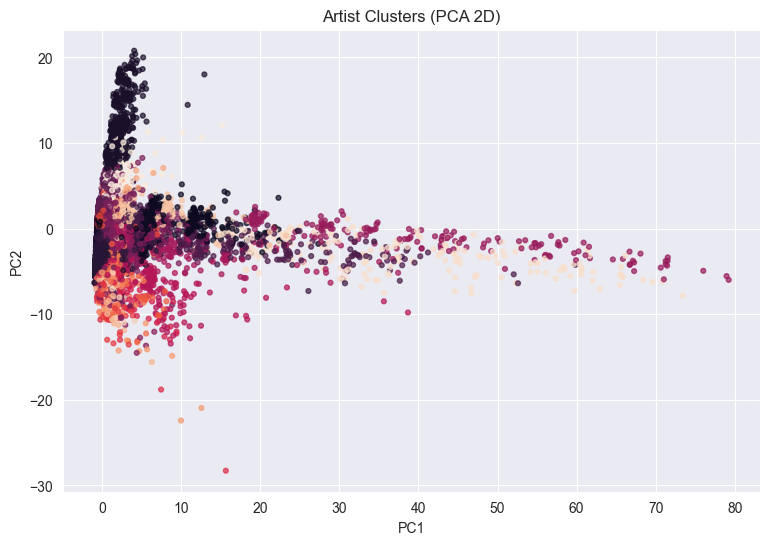

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# 2D PCA nur für Visualisierung
pca2 = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(9, 6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=artist_df["cluster"].values, s=12, alpha=0.7)
plt.title("Artist Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Train: Track-to-Track Similarity (Unsupervised Embeddings)

In diesem Schritt trainieren wir ein **unüberwachtes Similarity-Modell**, um „**Songs wie dieser**“-Empfehlungen ohne Nutzerhistorie zu ermöglichen.
Dazu lernen wir pro Track einen kompakten **Embedding-Vektor** ausschließlich aus den **Audio-Features** (z. B. Energy, Danceability, Valence).

**Warum?**
- Kein User-Log notwendig → funktioniert auch im **Cold-Start**.
- Embeddings liefern eine **kontinuierliche „Vibe“-Repräsentation** (statt harter Genre-Labels).
- Ähnlichkeitssuche wird effizient: Top-K über **Cosine Similarity** im Embedding-Space.

**Wie?**
- Wir skalieren Audio-Features und trainieren einen **Autoencoder**:
  - Encoder komprimiert Features → Embedding
  - Decoder rekonstruiert die Original-Features
- Nach dem Training erzeugen wir Embeddings für alle Tracks und berechnen Ähnlichkeit per **Cosine Similarity**.
- Ergebnis: `get_similar_tracks(track_id, k)` liefert die Top-K ähnlichsten Tracks.


In [170]:
# ============================================================
# TRACK-TO-TRACK SIMILARITY (UNSUPERVISED) – AUTOENCODER EMBEDDINGS
# Input:  track_df audio features (no targets)
# Output:
#   - track_embeddings: pd.DataFrame [n_tracks x emb_dim]
#   - helper: get_similar_tracks(track_id, k)
# ============================================================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# -------------------------
# 1) Choose audio feature columns
# -------------------------
AUDIO_CANDIDATES = [
    "acousticness", "danceability", "energy", "instrumentalness", "liveness",
    "loudness", "speechiness", "tempo", "valence", "duration_ms"
]
audio_cols = [c for c in AUDIO_CANDIDATES if c in track_df.columns]
assert len(audio_cols) >= 5, f"Not enough audio columns found. Found: {audio_cols}"

# Use only rows with all audio features present
X_audio = track_df[audio_cols].apply(pd.to_numeric, errors="coerce")
mask_audio = X_audio.notna().all(axis=1)
X_audio = X_audio.loc[mask_audio].copy()

# Optional: keep mapping back to track ids
TRACK_ID_COL = "track_id" if "track_id" in track_df.columns else ("id" if "id" in track_df.columns else None)
if TRACK_ID_COL is None:
    # fallback: use dataframe index as id
    track_ids = X_audio.index.to_numpy()
else:
    track_ids = track_df.loc[mask_audio, TRACK_ID_COL].astype(str).to_numpy()

# -------------------------
# 2) Scale
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_audio.values).astype(np.float32)

Xtr, Xva = train_test_split(X_scaled, test_size=0.15, random_state=42)

# -------------------------
# 3) PyTorch autoencoder
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_dim = X_scaled.shape[1]
emb_dim = min(16, max(4, in_dim))  # reasonable default


class AutoEncoder(nn.Module):
    def __init__(self, in_dim: int, emb_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, emb_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, in_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


model = AutoEncoder(in_dim, emb_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

batch_size = 2048
train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(Xva)), batch_size=batch_size, shuffle=False)


def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0
    n = 0
    for (xb,) in loader:
        xb = xb.to(device)
        if train:
            opt.zero_grad()
        recon, _ = model(xb)
        loss = loss_fn(recon, xb)
        if train:
            loss.backward()
            opt.step()
        total += float(loss.item()) * xb.size(0)
        n += xb.size(0)
    return total / max(1, n)


# Train
EPOCHS = 20
best_val = float("inf")
best_state = None

for ep in range(1, EPOCHS + 1):
    tr_loss = run_epoch(train_loader, train=True)
    va_loss = run_epoch(val_loader, train=False)
    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d} | train={tr_loss:.5f} | val={va_loss:.5f}")

if best_state is not None:
    model.load_state_dict(best_state)

# -------------------------
# 4) Create embeddings for all audio rows
# -------------------------
model.eval()
with torch.no_grad():
    Z = []
    loader_all = DataLoader(TensorDataset(torch.from_numpy(X_scaled)), batch_size=4096, shuffle=False)
    for (xb,) in loader_all:
        xb = xb.to(device)
        _, z = model(xb)
        Z.append(z.cpu().numpy())
    Z = np.vstack(Z)

track_embeddings = pd.DataFrame(Z, columns=[f"emb_{i}" for i in range(Z.shape[1])])
track_embeddings["track_key"] = track_ids

print("Embeddings ready:", track_embeddings.shape, "| emb_dim:", emb_dim)


Epoch 01 | train=0.48177 | val=0.11952
Epoch 05 | train=0.01442 | val=0.01372
Epoch 10 | train=0.00202 | val=0.00216
Epoch 15 | train=0.00082 | val=0.00081
Epoch 20 | train=0.00034 | val=0.00051
Embeddings ready: (298786, 10) | emb_dim: 9


In [171]:
# ============================================================
# Similarity search: cosine Top-K
# ============================================================

import numpy as np

# Build fast lookup
emb_cols = [c for c in track_embeddings.columns if c.startswith("emb_")]
key_to_idx = {k: i for i, k in enumerate(track_embeddings["track_key"].astype(str).tolist())}
E = track_embeddings[emb_cols].to_numpy().astype(np.float32)

# normalize for cosine similarity
E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)


def get_similar_tracks(track_key: str, k: int = 10):
    track_key = str(track_key)
    if track_key not in key_to_idx:
        raise KeyError(f"Unknown track_key: {track_key}")
    i = key_to_idx[track_key]
    q = E_norm[i:i + 1]  # 1 x d
    sims = (E_norm @ q.T).reshape(-1)  # cosine similarity
    sims[i] = -np.inf  # exclude itself
    top_idx = np.argpartition(-sims, kth=min(k, len(sims) - 1))[:k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]
    return pd.DataFrame({
        "track_key": track_embeddings["track_key"].iloc[top_idx].to_numpy(),
        "cosine_sim": sims[top_idx],
    })


# Example (pick any existing key)
example_key = str(track_embeddings["track_key"].iloc[0])
display(get_similar_tracks(example_key, k=10))


,track_key,cosine_sim
0,2lsWwJP3eG0yU3iq76SANG,0.999734
1,3p2cRc1OKggWNkR7VFYJT4,0.998870
2,05rQi8qD5Mt8jJklvV6crE,0.998797
3,13UanAG5s1hxhbm9PC50RI,0.998579
4,0k6xR5D9ogWML8LDAxaDOW,0.998451
5,5Mo37y9tkCRDm0zzfDvxFU,0.998428
6,3yROEFauqvezCpbtp1z8VJ,0.998273
7,5wABM6WbN3EqLPokF7AKyL,0.998248
8,15bIB84mBOoIiMR6wh1Sg1,0.998131
9,3tHyLVa23r2X3NXbaet3G5,0.998009



## Train: Mood Tags (Multi-Label)

Ziel: Mehrere Mood-Tags pro Track (z.B. happy, energetic, calm).

### Modellwahl (skalierbar)
Wir nutzen **One-vs-Rest** mit einem schnellen linearen Modell (SGDClassifier),
weil Multi-Label bedeutet:
- pro Label ein eigener Klassifikator
- sehr gut skalierbar auf große, sparse Feature-Matrizen



In [172]:


Xtr, Xte, Ytr, Yte = train_test_split(
    X_track_mood, Y_mood_clean,
    test_size=0.2, random_state=RANDOM_SEED
)

pre_mood, _, _ = build_preprocessor_linear(X_track_mood)

base_sgd = SGDClassifier(
    loss="log_loss",          # logistic
    alpha=1e-4,               # regularization (tune later)
    max_iter=2000,
    tol=1e-3,
    class_weight="balanced",
    random_state=RANDOM_SEED,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    shuffle=True
)

mood_model = OneVsRestClassifier(base_sgd, n_jobs=-1)

pipe_mood = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_mood),
    ("model", mood_model),
])

pipe_mood.fit(Xtr, Ytr)

proba = pipe_mood.predict_proba(Xte)          # (n_samples, n_labels)
pred  = (proba >= 0.5).astype(int)            # threshold can be tuned per-label

mood_micro_f1 = float(f1_score(Yte, pred, average="micro"))
mood_macro_f1 = float(f1_score(Yte, pred, average="macro"))
per_label_f1  = {col: float(f1_score(Yte[col], pred[:, i])) for i, col in enumerate(Yte.columns)}

mood_metrics = {
    "micro_f1": mood_micro_f1,
    "macro_f1": mood_macro_f1,
    "per_label_f1": per_label_f1
}

dump(pipe_mood, PATHS.models_dir / "mood_pipeline.joblib")
mood_metrics


{'micro_f1': 0.3717842502232599,
 'macro_f1': 0.30081797559999396,
 'per_label_f1': {'energetic': 0.015923147782602974,
  'danceable': 0.3889460427826457,
  'acoustic': 0.3639340798647792,
  'instrumental': 0.500946276716546,
  'happy': 0.046814892091021715,
  'sad': 0.2832366922634906,
  'chill': 0.5059246976988717}}

## `feature_config.json` speichern

An dieser Stelle exportieren wir die Datei **`feature_config.json`**.
Sie dient als **Scoring-Vertrag** zwischen Notebook 3 (Training) und Notebook 4 (Batch-Scoring).

### Warum diese Datei wichtig ist

Beim späteren Scoring (z. B. Millionen Datensätze) müssen **exakt dieselben Regeln** wie beim Training angewendet werden.
Die `feature_config.json` stellt **Reproduzierbarkeit und Konsistenz** sicher.

### Inhalt der `feature_config.json`

* **Feature-Listen**

  * numerische Features
  * kategoriale Features
  * Multi-Hot-Genre-Features

* **Genre-Encoding**

  * feste `top_genres`-Liste (gleiche Reihenfolge, gleiche Spalten)

* **Mood-Tags**

  * Schwellenwerte (z. B. Quantile für `valence`, `energy`)
  * Logik (`gt` / `lt`) und Tag-Namen

* **Hit-Label**

  * Parameter zur Hit-Definition (z. B. Perzentil)
  * sorgt für konsistente Zielerstellung

* **Metadaten (optional)**

  * Zeitstempel, Dataset-Version, Run-Infos


In [173]:
import json

feature_config = {
    "run_meta": RUN_META,
    "top_genres": top_genres,
    "mood_thresholds": {str(k): v for k, v in mood_thresholds.items()},  # JSON keys
    "mood_tags": MOOD_TAGS,

    # -------------------------
    # Features
    # -------------------------
    "track_features": {
        "numeric": TRACK_NUMERIC,
        "categorical": TRACK_CATEGORICAL,
        "genre_multi_hot_cols": list(track_genre_mh.columns) if "track_genre_mh" in globals() else [],
    },
    "artist_features": {
        "numeric_used_for_clustering": num_cols if "num_cols" in globals() else [],
        "genre_multi_hot_cols": list(artist_genre_mh.columns) if "artist_genre_mh" in globals() else [],
        "kmeans_k": int(K_CLUSTERS) if "K_CLUSTERS" in globals() else None,
    },

    # -------------------------
    # Targets / Label rules
    # -------------------------
    "targets": {
        # (A) Cohort ranking target
        "success_pct_in_cohort": {
            "cohort_definition": "YYYYMM based on release_year/release_month (track preferred, album fallback)",
            "column": "success_pct_in_cohort",
            "range": [0, 100],
        },
        # (B) Cohort residual target
        "success_residual_in_cohort": {
            "cohort_definition": "YYYYMM based on release_year/release_month (track preferred, album fallback)",
            "column": "success_residual_in_cohort",
            "definition": "track_popularity - mean_popularity_within_cohort",
        },
        # (C) Hit label
        "hit": {
            "hit_percentile_within_year": float(HIT_PERCENTILE),
            "hit_fallback_popularity_threshold": int(
                HIT_FALLBACK_POP_THRESHOLD) if "HIT_FALLBACK_POP_THRESHOLD" in globals() else None,
            "min_tracks_per_year": 200,
            "use_nonzero": True,
        },
        # (E) Mood tags
        "mood": {
            "type": "multi-label",
            "source": "quantile thresholds on selected audio features",
            "tags": [t[0] for t in MOOD_TAGS] if len(MOOD_TAGS) else [],
        },
        # (F) Artist trajectory
        "artist_trajectory": {
            "past_window_months": int(PAST_M) if "PAST_M" in globals() else 6,
            "future_window_months": int(FUTURE_M) if "FUTURE_M" in globals() else 6,
            "min_past_tracks": int(MIN_PAST_TRACKS) if "MIN_PAST_TRACKS" in globals() else 5,
            "breakout_quantile_within_year": float(BREAKOUT_Q) if "BREAKOUT_Q" in globals() else 0.90,
            "targets": ["y_growth", "y_breakout"],
        },
    },

    # -------------------------
    # Similarity model config (no targets)
    # -------------------------
    "similarity": {
        "track_to_track": {
            "type": "content-based",
            "no_targets": True,
            "baseline": "cosine_similarity_on_scaled_audio_features",
            "embedding_options": [
                "autoencoder_embeddings",
                "metric_learning_embeddings_optional"
            ],
            "positive_pairs_sources_for_metric_learning": [
                "same_artist (r_track_artist)",
                "shared_genre (r_artist_genre)",
                "shared_mood_tag (derived)"
            ],
        }
    }
}

(PATHS.models_dir / "feature_config_baseline.json").write_text(
    json.dumps(feature_config, indent=2),
    encoding="utf-8"
)
print("Saved feature_config.json")


Saved feature_config.json


## Reports schreiben (JSON)

In diesem Schritt speichern wir die wichtigsten Ergebnisse aus Notebook 3 als **maschinenlesbare JSON-Reports**.

### Warum JSON-Reports?
Reine Notebook-Ausgaben sind nicht reproduzierbar.
JSON ermöglicht:

- Vergleich von Experimenten (Baseline vs. Tuning)
- Nachverfolgung von Verbesserungen über Zeit
- Nutzung in Dashboards oder CI-Pipelines
- Nachvollziehbarkeit für Notebook 4

### Was wird gespeichert?
- **Modell-Metriken** (Regression, Klassifikation, Mood, Clustering)
- **Dataset-Größen** (Tracks, Alben, Artists, Feature-Matrizen)

### Speicherort
Die Reports werden im Ordner **`reports/`** abgelegt
(z. B. `metrics_report.json`) und dienen als **zentrale Referenz** für diesen Run.


In [174]:
import json


def safe_get(name: str):
    return globals().get(name, None)


reports = {
    # -------------------------
    # Track tasks (new set)
    # -------------------------
    "success_percentile_within_cohort": safe_get("success_pct_metrics"),  # (A) regression/ranking metrics
    "success_residual_within_cohort": safe_get("success_resid_metrics"),  # (B) regression metrics
    "hit_prediction": safe_get("hit_metrics"),  # (C)
    "mood_multilabel": safe_get("mood_metrics"),  # (E)

    # -------------------------
    # Artist tasks
    # -------------------------
    "artist_trajectory_growth": safe_get("artist_growth_metrics"),  # (F) regression metrics
    "artist_trajectory_breakout": safe_get("artist_breakout_metrics"),  # (F) classification metrics

    # -------------------------
    # Optional artifacts
    # -------------------------
    "artist_clustering": safe_get("artist_cluster_artifact"),
    "track_similarity": safe_get("track_similarity_artifact"),  # e.g. retrieval examples / embedding stats

    # -------------------------
    # Dataset shapes (keep album_df if you still keep it)
    # -------------------------
    "dataset_shapes": {
        "track_df": [int(track_df.shape[0]), int(track_df.shape[1])] if "track_df" in globals() else None,
        "album_df": [int(album_df.shape[0]), int(album_df.shape[1])] if "album_df" in globals() else None,
        "artist_df": [int(artist_df.shape[0]), int(artist_df.shape[1])] if "artist_df" in globals() else None,
        "X_track": [int(X_track.shape[0]), int(X_track.shape[1])] if "X_track" in globals() else None,
        "artist_panel": [int(artist_panel.shape[0]),
                         int(artist_panel.shape[1])] if "artist_panel" in globals() else None,
        "X_artist_panel": [int(X_artist_panel.shape[0]),
                           int(X_artist_panel.shape[1])] if "X_artist_panel" in globals() else None,
    },
}

(PATHS.reports_dir / "metrics_report.json").write_text(
    json.dumps(reports, indent=2),
    encoding="utf-8"
)
print("Wrote metrics report:", PATHS.reports_dir / "metrics_report.json")


Wrote metrics report: ..\data\reports\03_target_and_features\slice_001\metrics_report.json


## Speicher von Datasets

In [175]:
# =========================
# Datasets für Notebook 4 speichern
# =========================
# Saves all datasets that have targets for later training / hypertuning:
#   (A) success_pct_in_cohort
#   (B) success_residual_in_cohort
#   (C) hit
#   (E) mood multi-label
#   (F) artist trajectory: growth + breakout
# =========================

from pathlib import Path
import pandas as pd

DATA_DIR = Path("../data/baseline_models_datasets") / SAMPLE_NAME
DATA_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# (A) Success Percentile within Cohort
# -------------------------
X_track_success_pct.to_parquet(DATA_DIR / "X_track_success_pct.parquet", index=False)
pd.Series(y_success_pct_clean, name="success_pct_in_cohort").to_frame().to_parquet(
    DATA_DIR / "y_success_pct.parquet", index=False
)

# -------------------------
# (B) Success Residual within Cohort
# -------------------------
X_track_success_resid.to_parquet(DATA_DIR / "X_track_success_residual.parquet", index=False)
pd.Series(y_success_residual_clean, name="success_residual_in_cohort").to_frame().to_parquet(
    DATA_DIR / "y_success_residual.parquet", index=False
)

# -------------------------
# (C) Hit Prediction
# -------------------------
X_track_hit.to_parquet(DATA_DIR / "X_track_hit.parquet", index=False)
pd.Series(y_hit_clean, name="is_hit").to_frame().to_parquet(
    DATA_DIR / "y_hit.parquet", index=False
)

# -------------------------
# (E) Mood Multi-Label
# -------------------------
# Save only if these exist (robust for notebook execution order)
if "X_track_mood" in globals() and "Y_mood_clean" in globals():
    X_track_mood.to_parquet(DATA_DIR / "X_track_mood.parquet", index=False)
    Y_mood_clean.to_parquet(DATA_DIR / "Y_mood.parquet", index=False)

# -------------------------
# (F) Artist Trajectory (Panel)
# -------------------------
if "X_artist_panel" in globals() and X_artist_panel is not None:
    X_artist_panel.to_parquet(DATA_DIR / "X_artist_panel.parquet", index=False)

    # Targets
    pd.Series(y_artist_growth_clean, name="artist_growth").to_frame().to_parquet(
        DATA_DIR / "y_artist_growth.parquet", index=False
    )
    pd.Series(y_artist_breakout_clean, name="artist_breakout").to_frame().to_parquet(
        DATA_DIR / "y_artist_breakout.parquet", index=False
    )

print("Datasets gespeichert in:", DATA_DIR.resolve())
print("Files:")
for p in sorted(DATA_DIR.glob("*.parquet")):
    print(" -", p.name)


Datasets gespeichert in: C:\GitHub\data-science\uni-course\spotify-data-project\data\datasets\slice_001
Files:
 - X_artist_panel.parquet
 - X_track_hit.parquet
 - X_track_mood.parquet
 - X_track_success_pct.parquet
 - X_track_success_residual.parquet
 - y_artist_breakout.parquet
 - y_artist_growth.parquet
 - y_hit.parquet
 - Y_mood.parquet
 - y_success_pct.parquet
 - y_success_residual.parquet
